# Cell 5 from Kylie PROTOCOL 3

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. I'll start with one of the smaller data sets.

The protocols that I have the myokit version are 2, 3, 4, 5

In this notebook:
- Code an exponential approximation 
- load data protocol 
- epsilon calulation
- leak current calculation
- minimize residuals
- Number of open channels transformation and quadratic fit


In [2]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
#from scipy.interpolate import interp1d,  UnivariateSpline, splrep, splev, make_lsq_spline, BSpline
from scipy.optimize import minimize, minimize_scalar#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

# For the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

def Quadratic_fit_for_N(N, x, data):
    quadratic_fit = x * (1 - x / N) 
    residuals = quadratic_fit - data
    return sum(residuals**2)

## Meta parameters

All the jump voltages have a time at the beggining that we will remove. We'll remove 50ms 
times_to_skip = 50 

Flag to decide if the spline fit has been saved or not (saved_splines)

Use of 4 exponentials: NumExpo_flag = True ; or 3 exponentials NumExpo_flag = False

In [4]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials
saved_splines = True
FileNameSplines = 'protocol3_cell5_splines_params_largerCurrents.npy' 
FileNameSplinesWeights = 'protocol3_cell5_splines_params_largerCurrents_weights.npy'
if saved_splines:
    print('This code will load the splines parameters instead of fitting them')

This code will load the splines parameters instead of fitting them


## Focus on one protocol first

Start with protocol 3, cell 5

To do:
- divide wrt constant V intervals
- investigate the spline interpolation
- get splines per interval
- get residuals
- ploy residuals vs 1. Current, 2. Voltage, 3. time

## Separate by V level

The current and time is partitinonated to a level of V

In [5]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')


# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))


42


## Define color scheme by V's

There are 9 unique V's. (-120, -80:20:60), So I need 9 unique colors. 

In [6]:
# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
#pr3_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']
#pr3_unique_Vs_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])


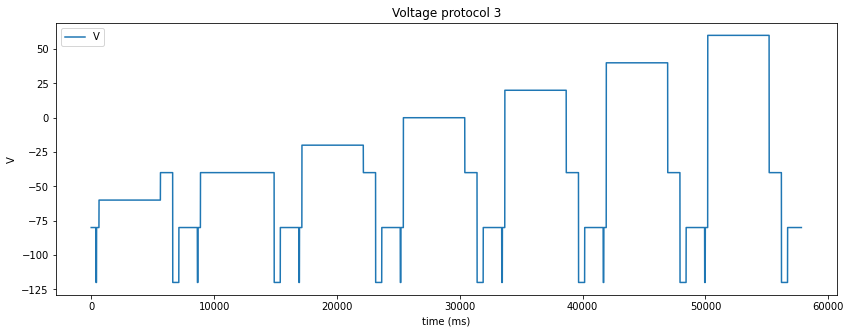

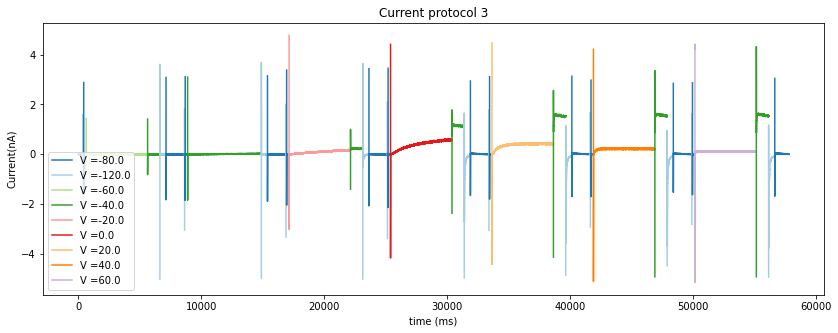

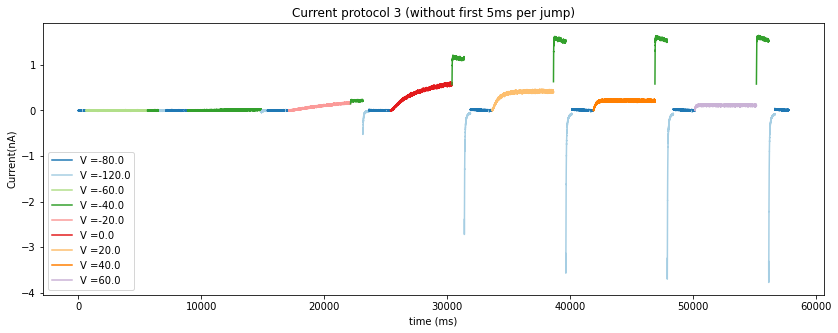

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(pr3_time, pr3_voltage,'-', label='V')
plt.xlabel('time (ms)')
plt.ylabel('V')
plt.title('Voltage protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
#plt.ylim([-.1,.1])
#plt.xlim([0,2000])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(14, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], pr3_current_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()



## Estimate epsilon from V = -80

- load data for V=-80
- take residuals ? 
    - does it makes sense or is it directly take values since the mean current is zero?
- Get R^2 by batch and mean
- Get the mean of the R^2

15


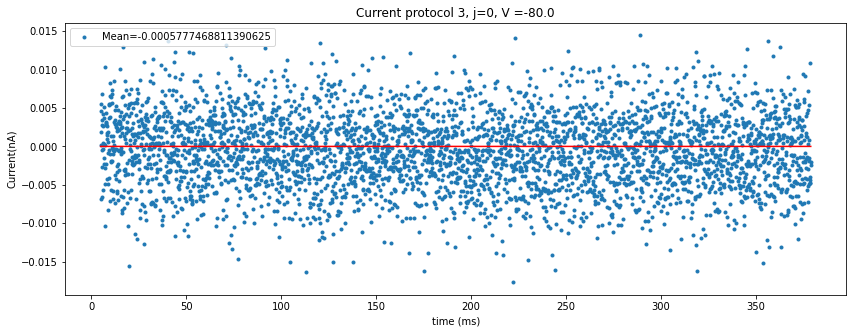

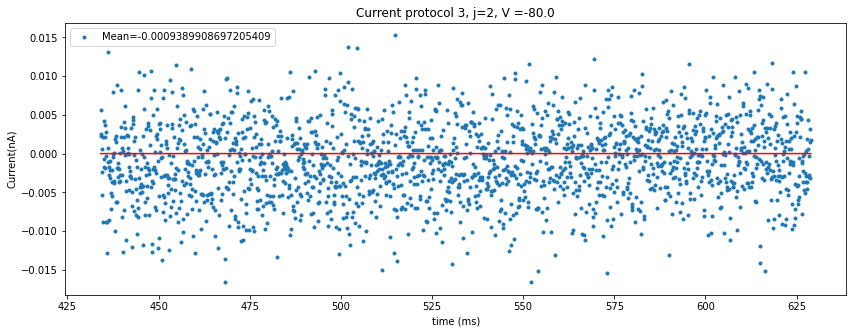

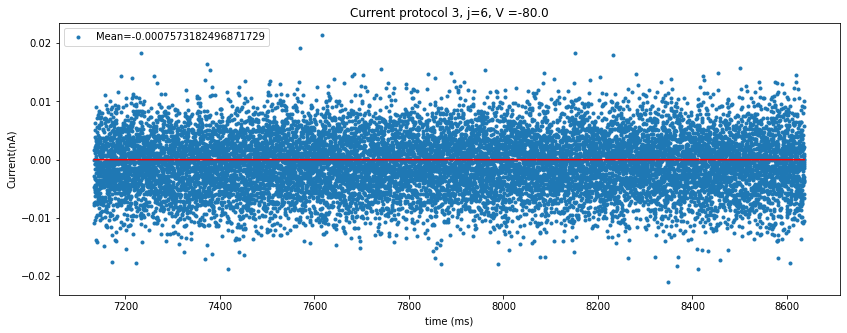

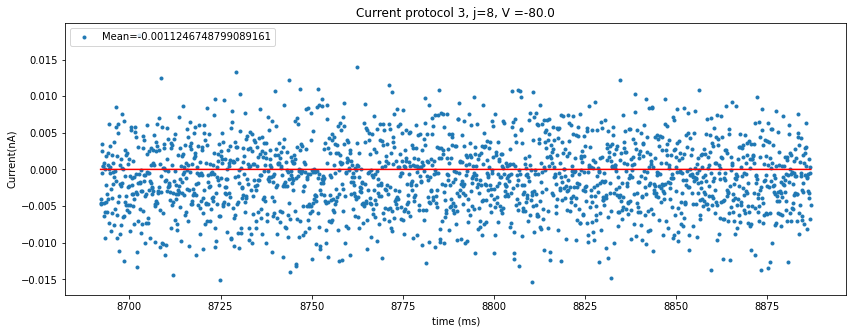

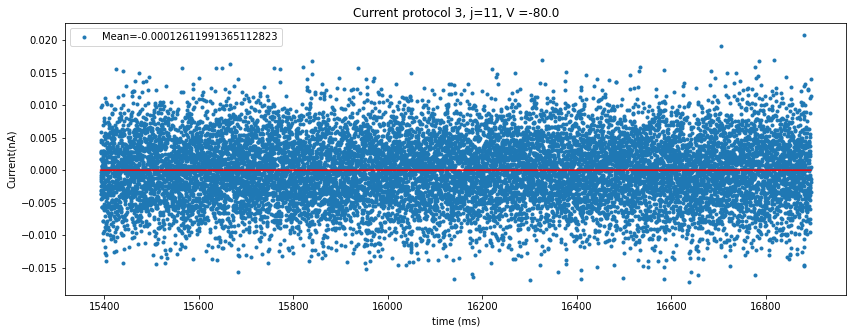

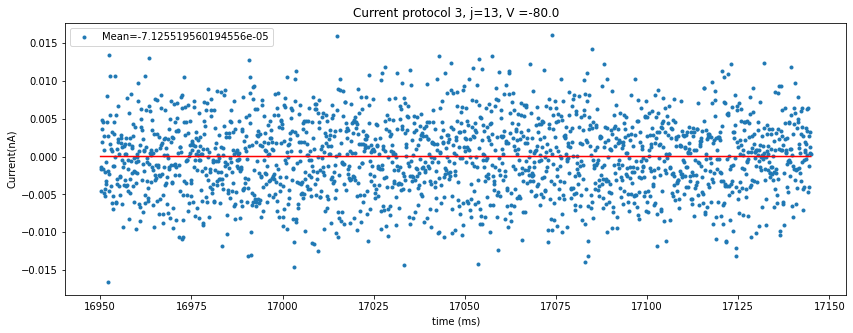

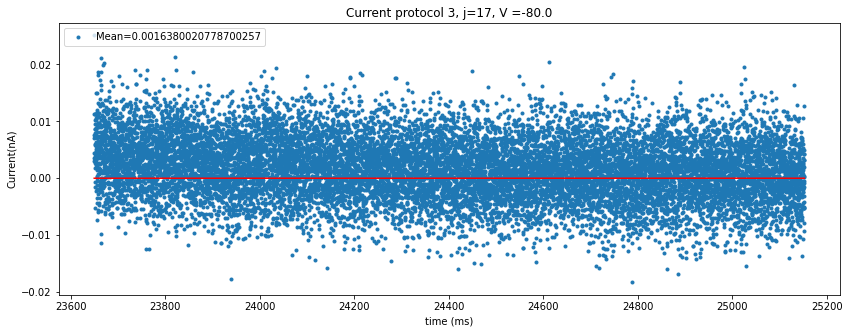

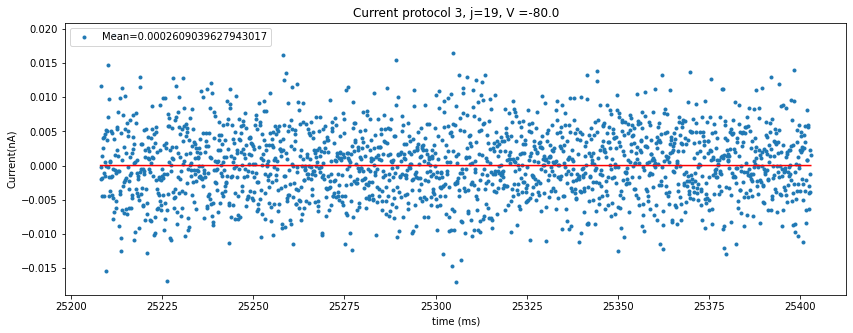

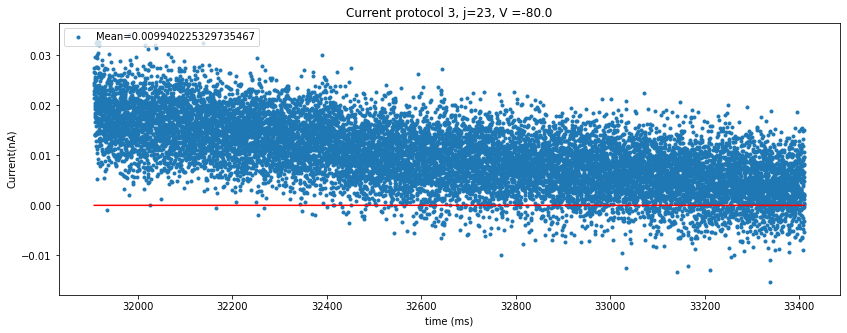

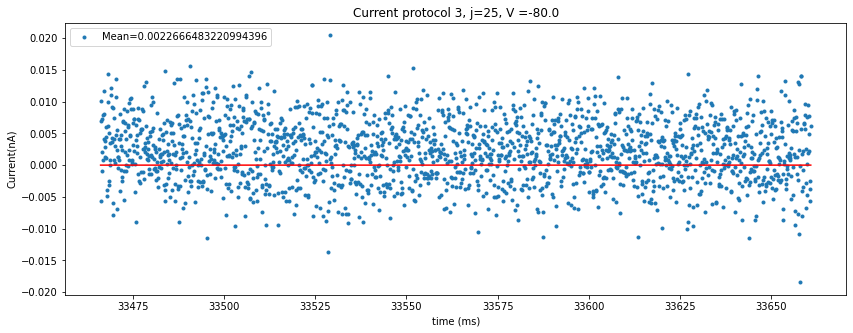

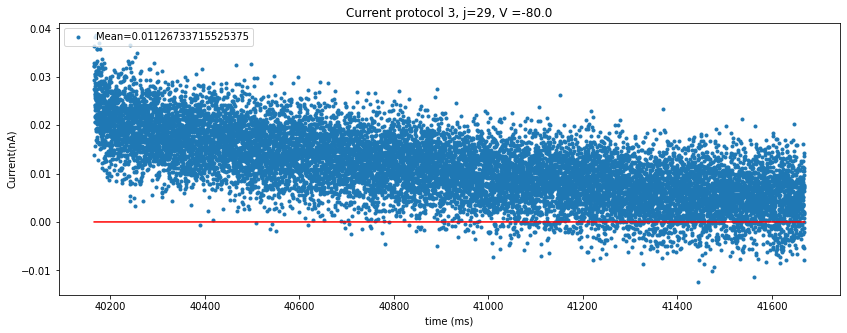

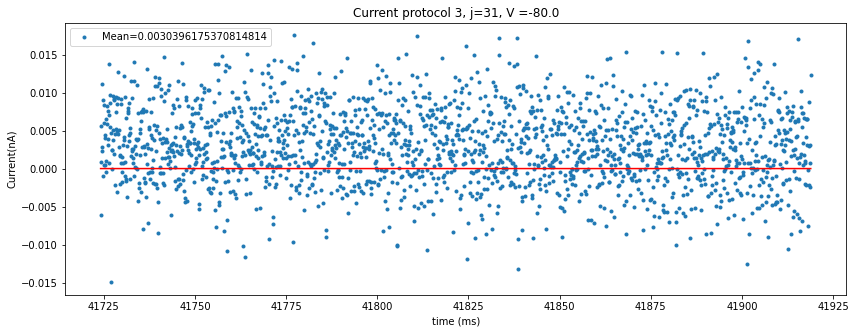

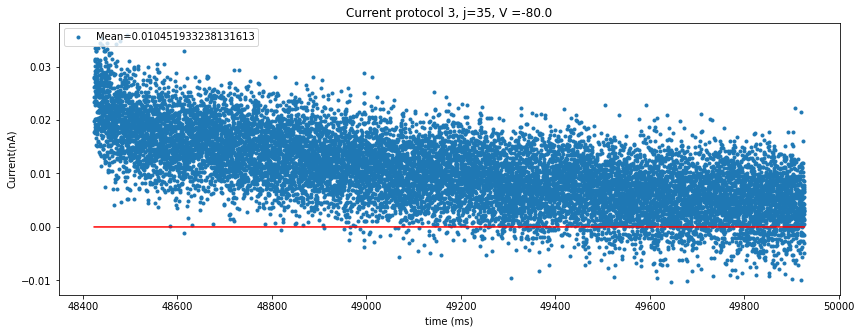

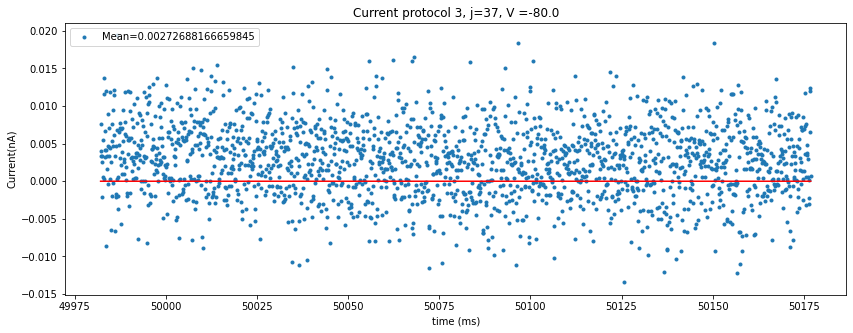

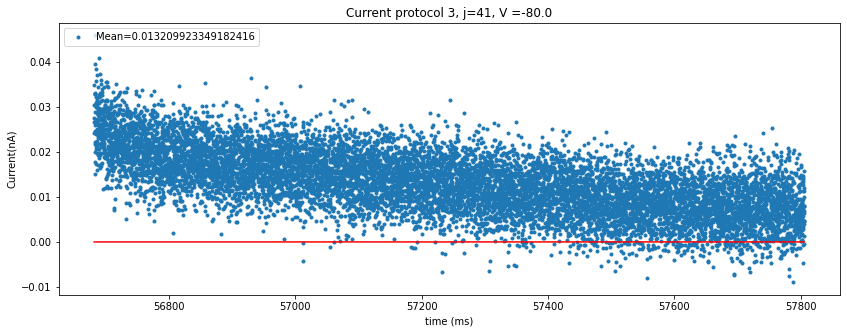

In [8]:
# Find where V = -80
print(sum(pr3_voltage_constV==-80))
index_neg80 = np.nonzero(pr3_voltage_constV==-80)
index_neg80 = index_neg80[0]
index_neg80_meanzero = []
V80_means = np.zeros(len(index_neg80))
V80_vars = np.zeros(len(index_neg80))

#pr3_current_constV_all80s =np.array([])
pr3_current_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_means[k] = np.mean(pr3_current_constV_without_first5ms[j])
    V80_vars[k] = np.var(pr3_current_constV_without_first5ms[j])
    #pr3_current_constV_all80s = np.append(pr3_current_constV_all80s, pr3_current_constV[j][times_to_skip:])
    if np.abs(V80_means[k]) < 0.009:
        index_neg80_meanzero.append(j)
        pr3_current_constV_80smeanzero =np.append(pr3_current_constV_80smeanzero, pr3_current_constV_without_first5ms[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j],'.', color = pr3_voltage_constV_colors[j], label='Mean='+str(np.mean(pr3_current_constV_without_first5ms[j])))
    plt.plot(pr3_time_constV_without_first5ms[j],np.zeros(len(pr3_time_constV_without_first5ms[j])), color = 'r')
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr3_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


In [9]:
#print(V80_means)
#print(V80_vars)
print('---- ALL V=-80 -------- V=-80 AND |mean|<0.009---')
print('Mean of means by jump:')
print([np.mean(V80_means), np.mean(V80_means[np.abs(V80_means)<0.009])])
print('Mean of all the time steps together for mean<0.009:')
print([0, np.mean(pr3_current_constV_80smeanzero)])


print('Mean of Vars per jump:')
#print(V80_vars[np.abs(V80_means)<0.009])
epsilonA = np.mean(V80_vars)
epsilonB = np.mean(V80_vars[np.abs(V80_means)<0.002])
print([epsilonA, epsilonB])


print('Var of the time steps together: for mean<0.009:')
epsilon1 = np.var(pr3_current_constV_80smeanzero)
print([0, epsilon1])



---- ALL V=-80 -------- V=-80 AND |mean|<0.009---
Mean of means by jump:
[0.0034136911099358785, 0.0005759952342486302]
Mean of all the time steps together for mean<0.009:
[0, 0.0003391021796864299]
Mean of Vars per jump:
[3.0527468270471126e-05, 2.4921364042559807e-05]
Var of the time steps together: for mean<0.009:
[0, 2.702548900276314e-05]


# Leak current

I'll check the transition between V=-80 to V=-120 to check if the leak current has been removed from the data set. 

For protocol 3, we always have the sequence of Vs: 40, -120, -80, -120, -80. And I'm interested in the -80,-120, -80 part. 

[ 0  2  6  8 11 13 17 19 23 25 29 31 35 37]
[ 0  6 11 17 23 29 35]


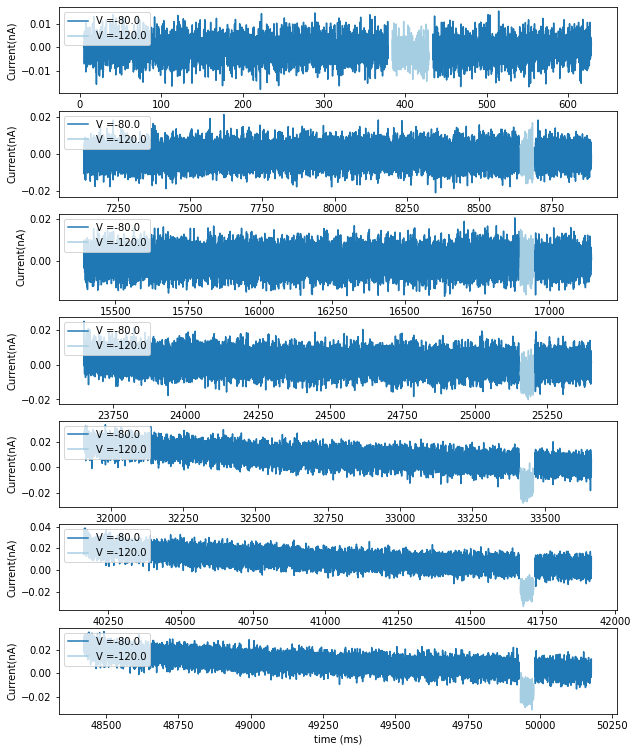

In [10]:
index_leak80 = np.nonzero(pr3_voltage_constV[:-2]==-80)
index_leak80 = index_leak80[0]
index_leak120 = np.nonzero(pr3_voltage_constV[index_leak80+1]==-120)
index_leak120 = index_leak120[0]
print(index_leak80)
print(index_leak80[index_leak120])

index_leak = index_leak80[index_leak120] # Index for the -80 to start the -80,-120,-80 jump. 


fig, axs = plt.subplots(len(index_leak),1, figsize=(10, 13))
axs = axs.ravel()

for k in range(len(index_leak)):
    j = index_leak[k]
    
    axs[k].plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j], color = pr3_voltage_constV_colors[j], label=pr3_voltage_constV_labels_full[j])
    axs[k].plot(pr3_time_constV_without_first5ms[j+1], pr3_current_constV_without_first5ms[j+1], color = pr3_voltage_constV_colors[j+1], label=pr3_voltage_constV_labels_full[j+1])
    axs[k].plot(pr3_time_constV_without_first5ms[j+2], pr3_current_constV_without_first5ms[j+2], color = pr3_voltage_constV_colors[j+2], label='_nolegend_')
    axs[k].set_ylabel('Current(nA)')
    axs[k].legend(loc='upper left')
axs[k].set_xlabel('time (ms)')

plt.show()

## Voltage larger or equal than -40


In [11]:
print(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]
print(len(index_largerCurrents))

splines_largerCurrents = [None] * len(index_largerCurrents)
splines_params_largerCurrents = [None] * len(index_largerCurrents)
residuals2_largerCurrents = [None] * len(index_largerCurrents)
times_largerCurrents = [None] * len(index_largerCurrents)
currents_largerCurrents = [None] * len(index_largerCurrents)
deltat_largerCurrents = np.zeros(len(index_largerCurrents))


splines_largerCurrents_weights = [None] * len(index_largerCurrents)
splines_params_largerCurrents_weights= [None] * len(index_largerCurrents)
residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)

# Separate times and currents:

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    currents_largerCurrents[index_i] = pr3_current_constV_without_first5ms[i]
    deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]


[False False False False  True False False False False  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
12


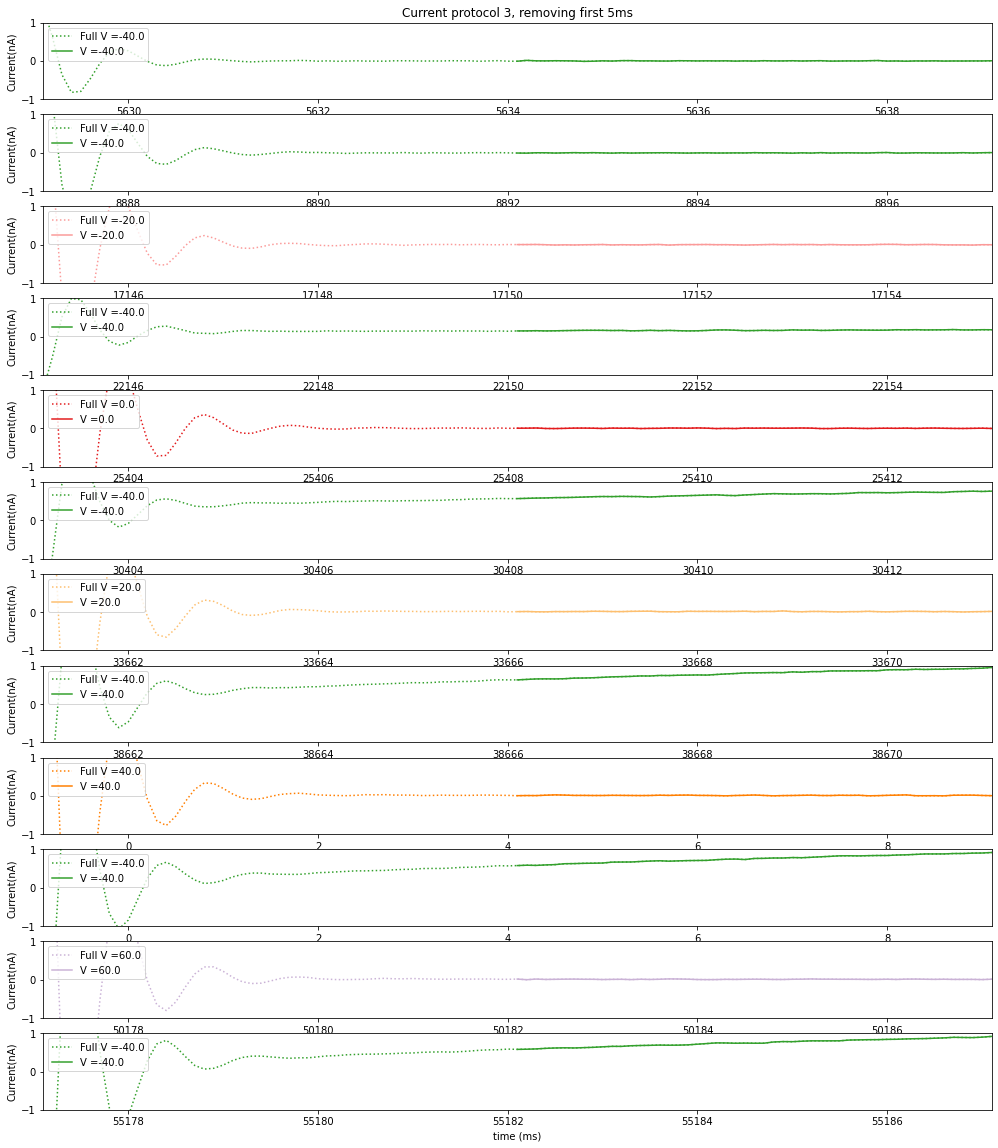

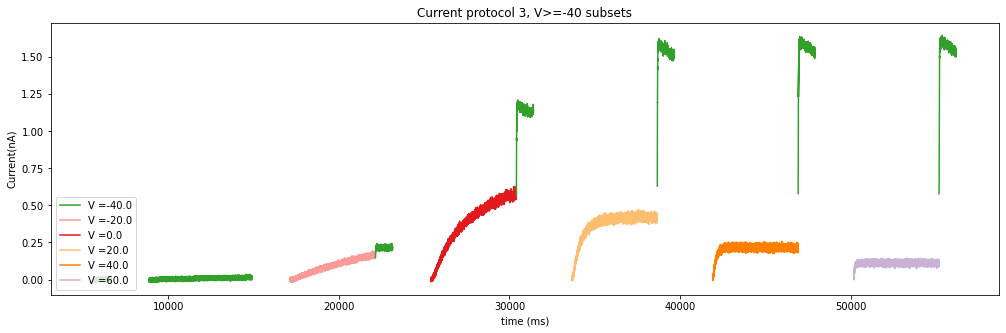

In [12]:

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    axs[index_i].plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],':',color = pr3_voltage_constV_colors[i], label='Full ' + pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr3_time[pr3_Vtimes[i]],pr3_time[pr3_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
#plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()


In [13]:
# Find or load the splines parameters. NO WEIGHTS
if saved_splines:
    # Load the parameters of the spline:
    splines_params_largerCurrents = np.load(FileNameSplines)
    for index_i in range(len(index_largerCurrents)): 
        splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
    print('Loading DONE')
else:
    # CMA fit, NO weights. If paramerers had been save, skip this cell
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
        splines_params_largerCurrents[index_i] = es[0]
        splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
    # SAve the parameters of the spline:
    np.save(FileNameSplines,np.array(splines_params_largerCurrents))
    print('Fitting DONE')



Loading DONE


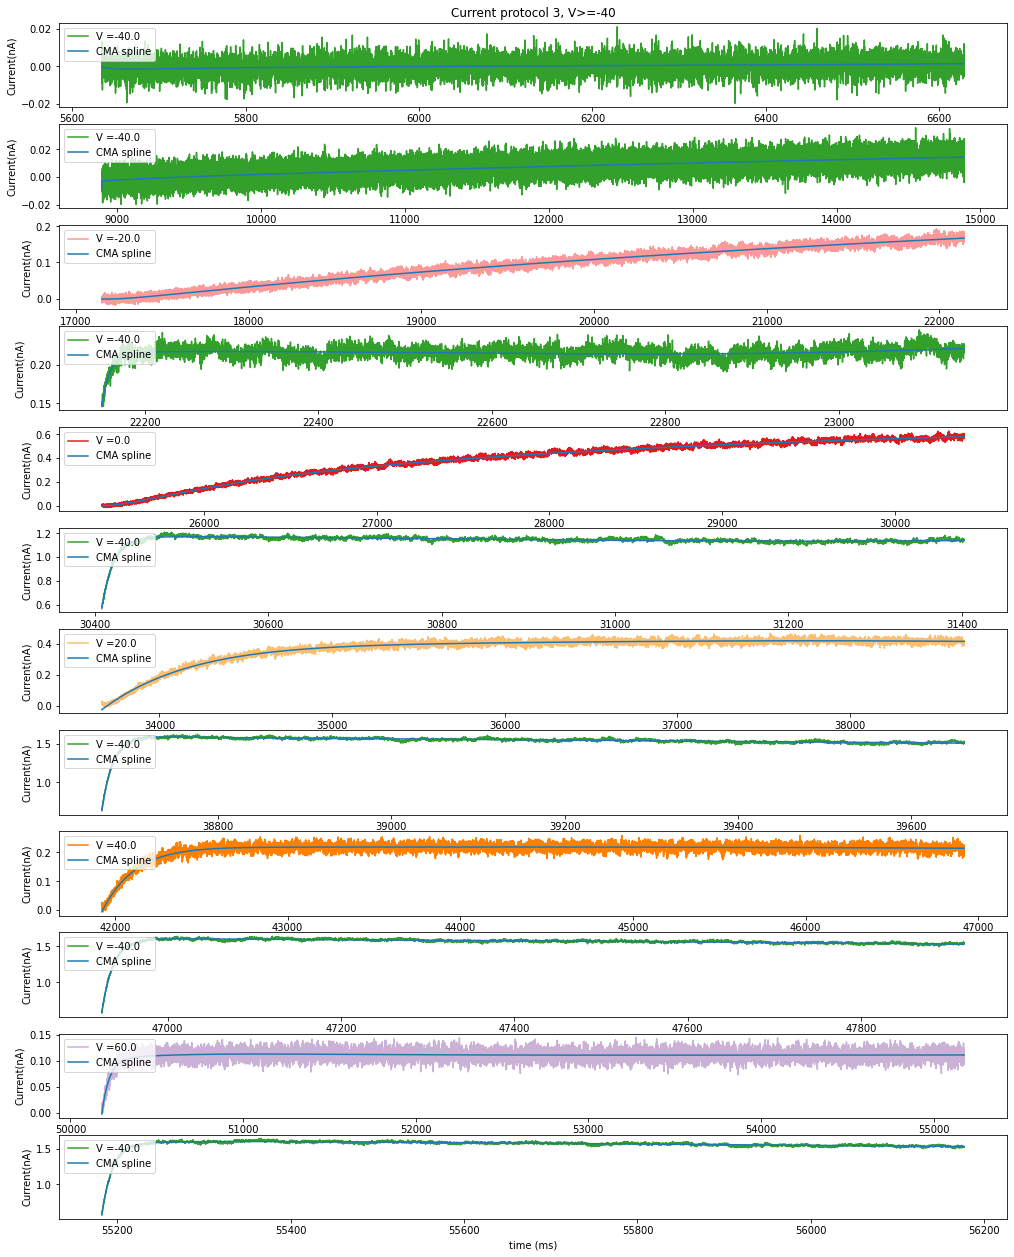

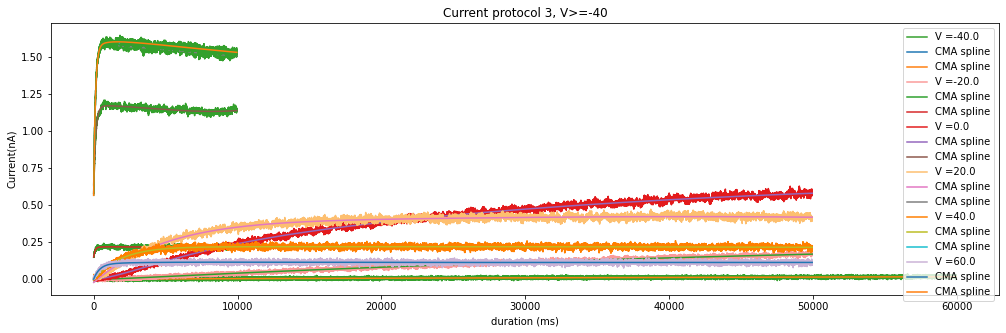

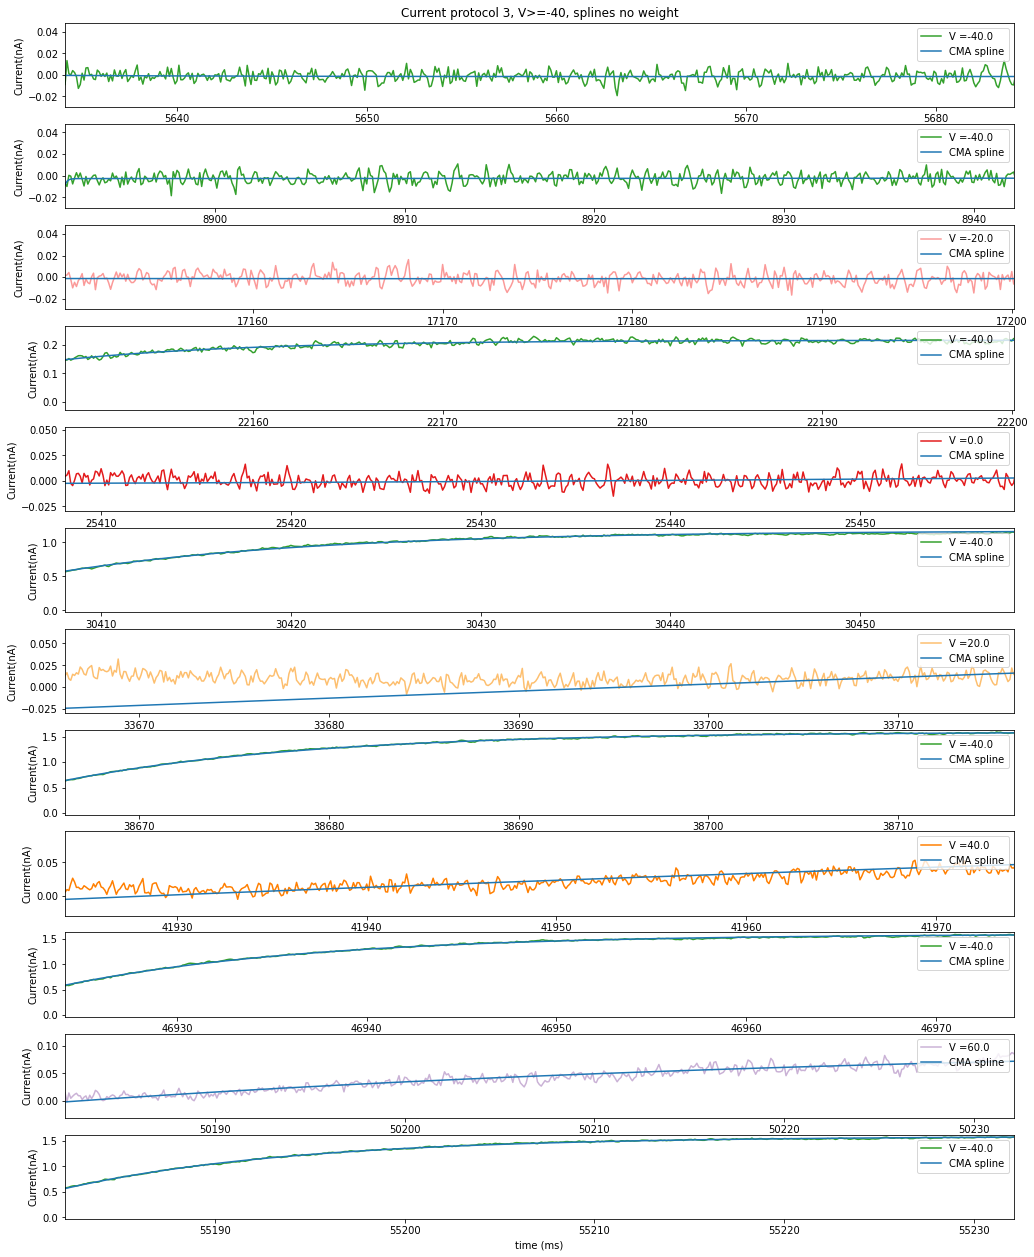

In [14]:
# Trying a better plot
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper right')
plt.show()

# Zoom with no weights

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0],times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, splines no weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

In [15]:
# Find or load the splines parameters. WITH WEIGHTS
if saved_splines:
    # Load the parameters
    splines_params_largerCurrents_weights = np.load(FileNameSplinesWeights)
    for index_i in range(len(index_largerCurrents)): 
        splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    print('Loading with weights DONE')
else:
    # CMA_fit with weighting residuals
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
        splines_params_largerCurrents_weights[index_i] = es[0]
        splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    # SAVE THE PARAMETERS
    np.save(FileNameSplinesWeights,np.array(splines_params_largerCurrents_weights))
    print('Fitting with weights DONE')


Loading with weights DONE


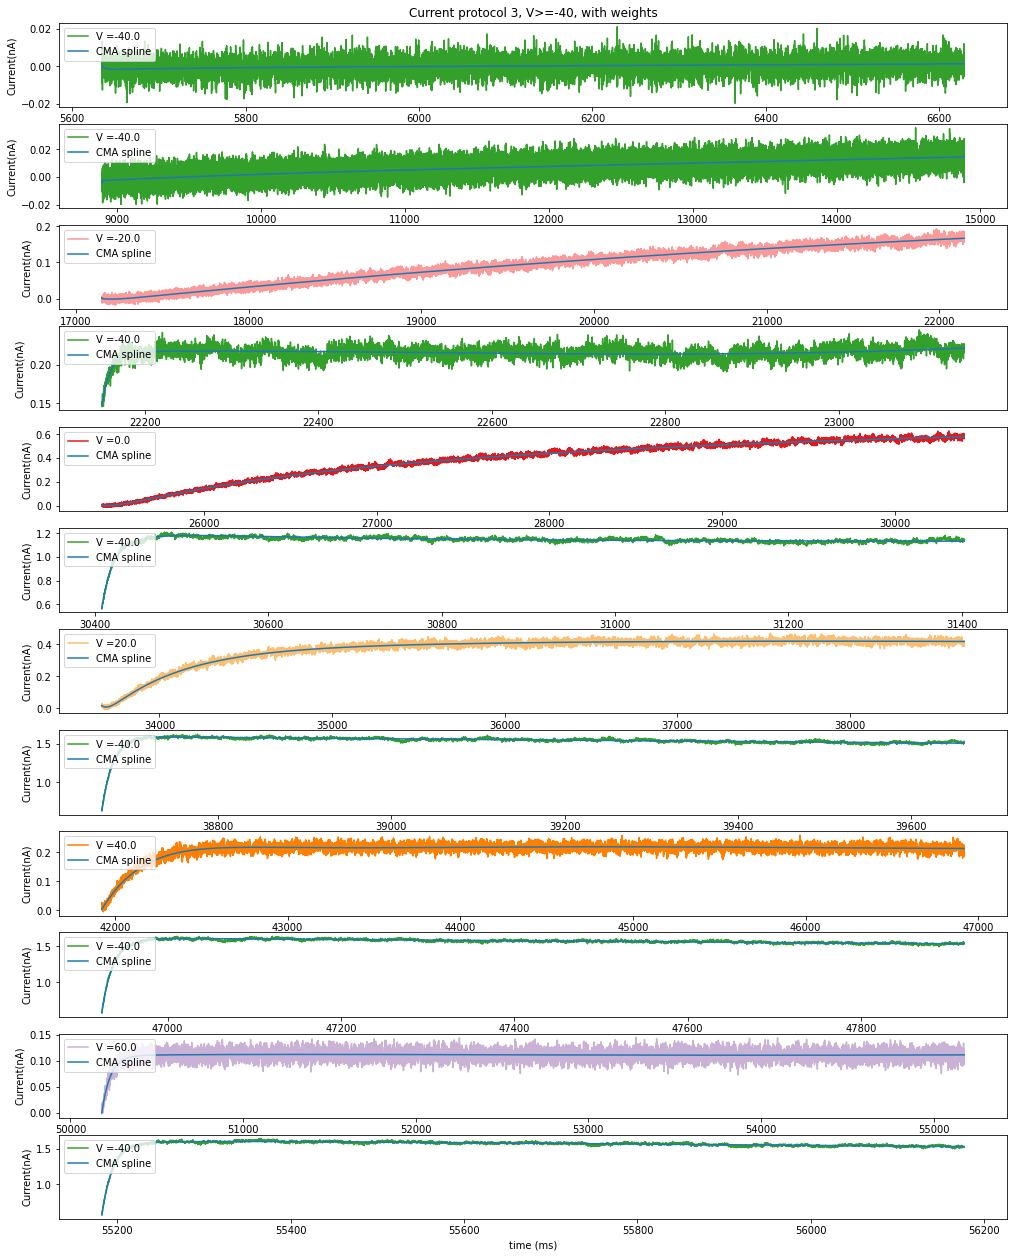

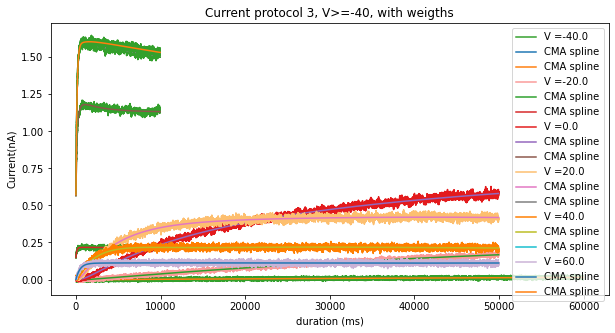

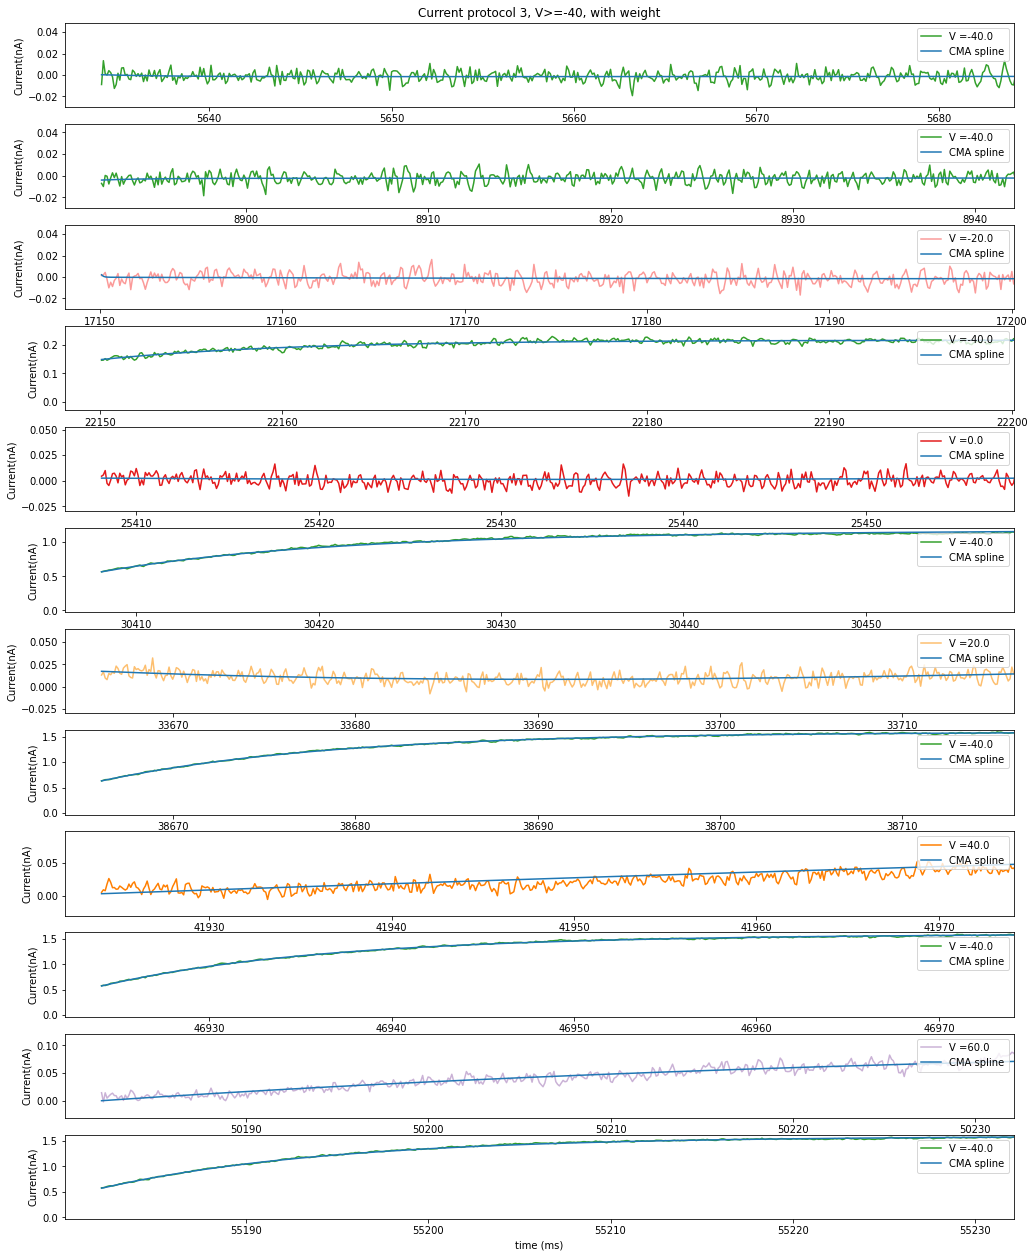

In [16]:
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents_weights[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()

# Zoom

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0]-2,times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents_weights[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

## Start analysis of the residuals (noise)

We will use the data with splines AND weights: "spline_..._weights"

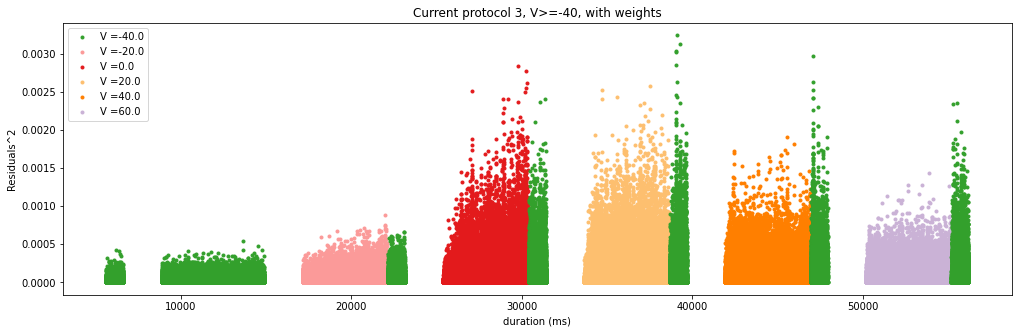

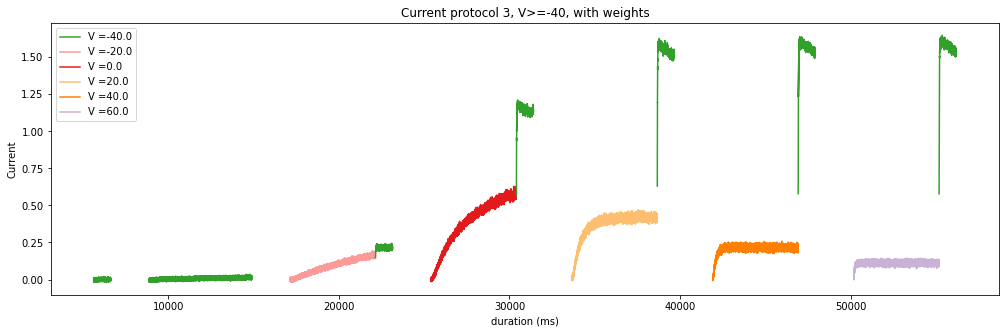

In [17]:
# Residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = currents_largerCurrents[index_i] - splines_largerCurrents_weights[index_i]
    residuals2_largerCurrents_weights[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Current')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

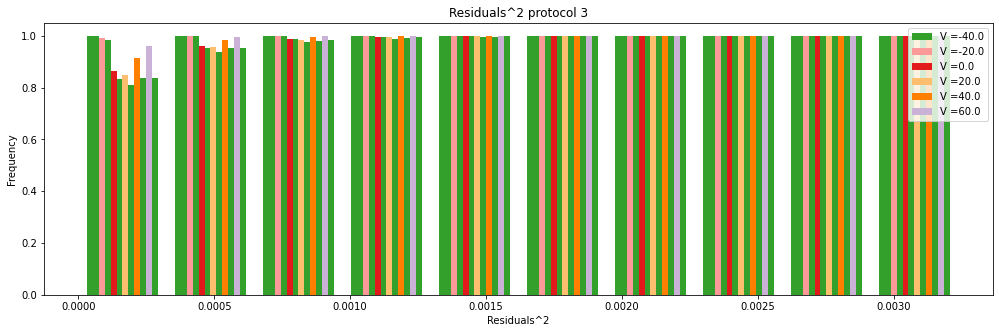

In [18]:
# Histograms of the residuasl
plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights, bins = 10, density =True, cumulative=True, color = np.array(pr3_voltage_constV_colors)[index_largerCurrents.astype(int)], label=pr3_voltage_constV_labels_simple[index_largerCurrents.astype(int)])
plt.legend(loc='upper right')
plt.xlabel('Residuals^2')
plt.ylabel('Frequency')
plt.title('Residuals^2 protocol 3')

plt.show()

## Autocorrelation and binning by time

If my cut is autocor_cut = 0.05, the min lag that has every autocorrelation smaller than 0.05: [  5.   4. 123.  65. 472. 164.  81. 500.  36. 357.  12. 115.] Then bin should be around 500

If autocor_cut = 0.1, then [  0.   0.  18.  20.  94.  60.  37.  72.  18. 114.   9.  68.] Then Bin should be around 100

If autocor_cut = 0.25, then [ 0.  0.  1.  1. 19. 19. 10. 37.  2. 36.  1. 10.] Then Bin should be around 40

If autocor_cut = 0.5, then [0. 0. 0. 0. 1. 2. 1. 2. 1. 2. 0. 1.] Then Bin should be around 3

More or less the first auto_cut that gives me a bin size of 10 is when auto_cut = 0.385. [0. 0. 0. 0. 2. 2. 2. 9. 1. 3. 1. 2.]




(9949,)


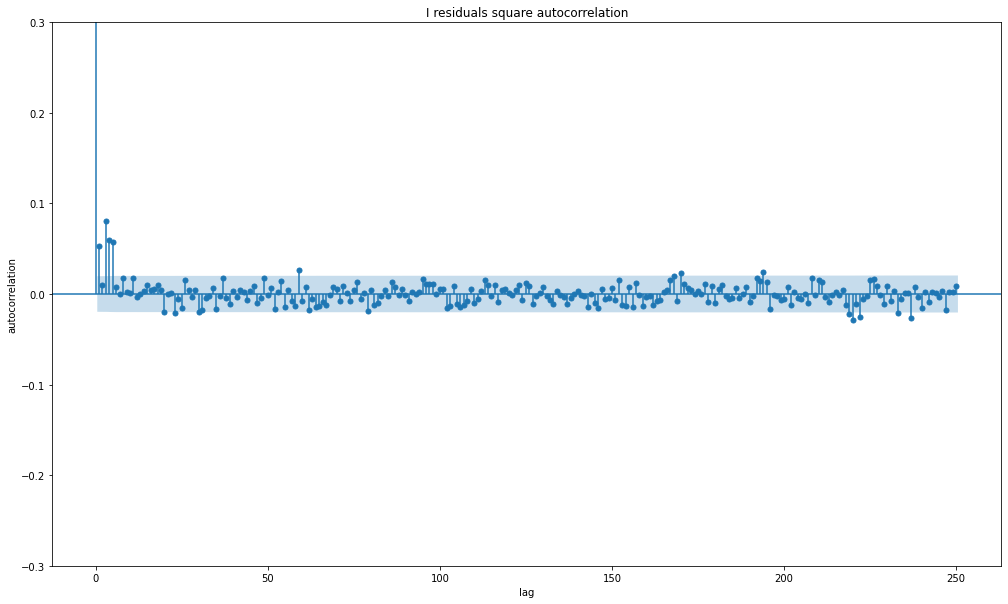

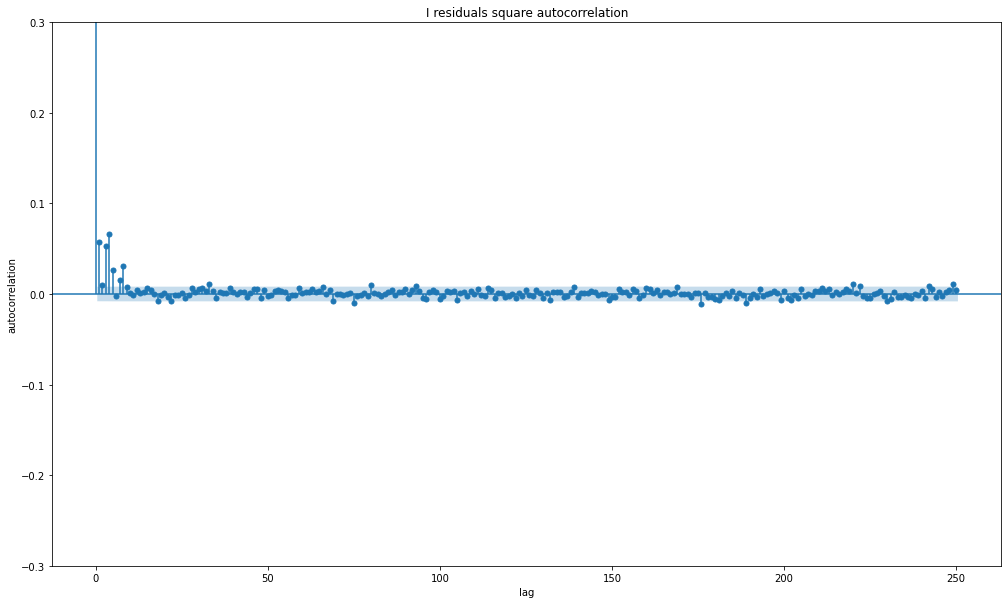

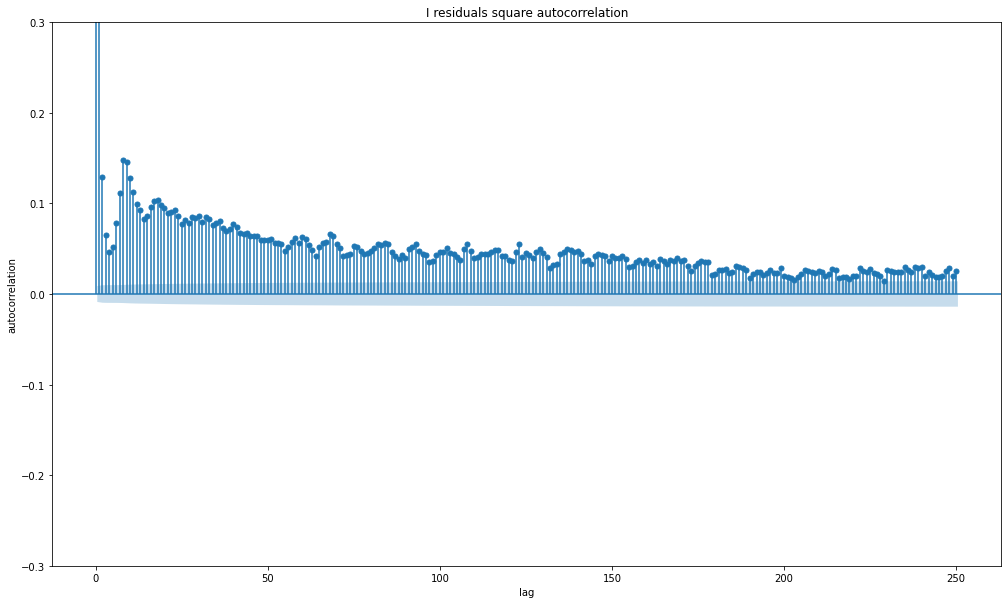

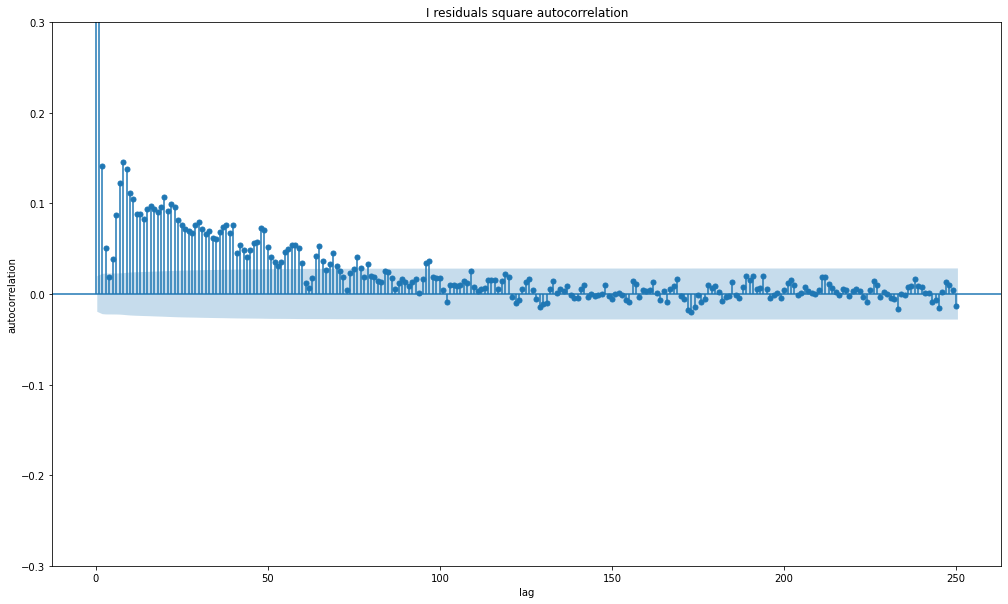

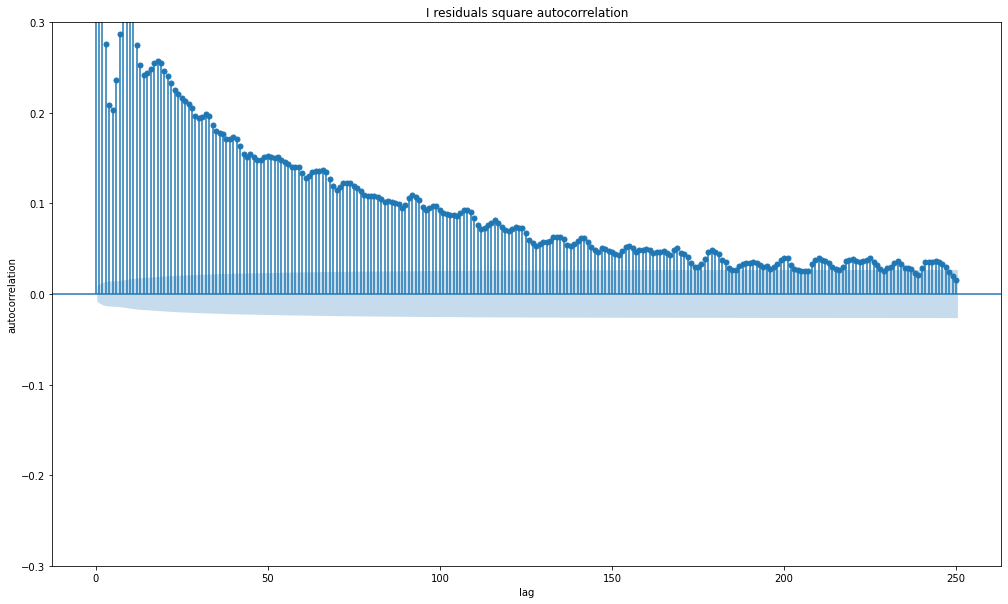

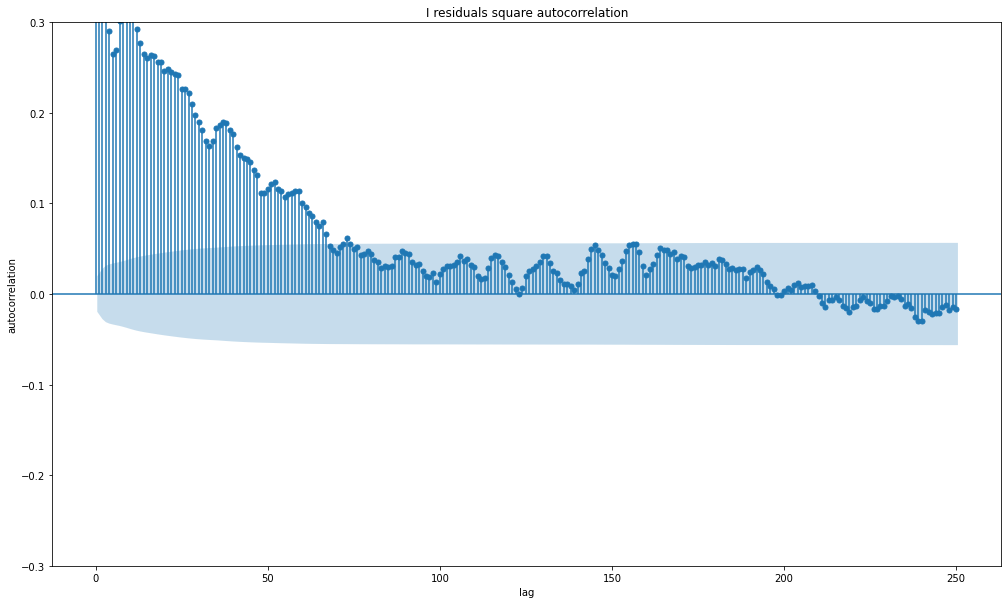

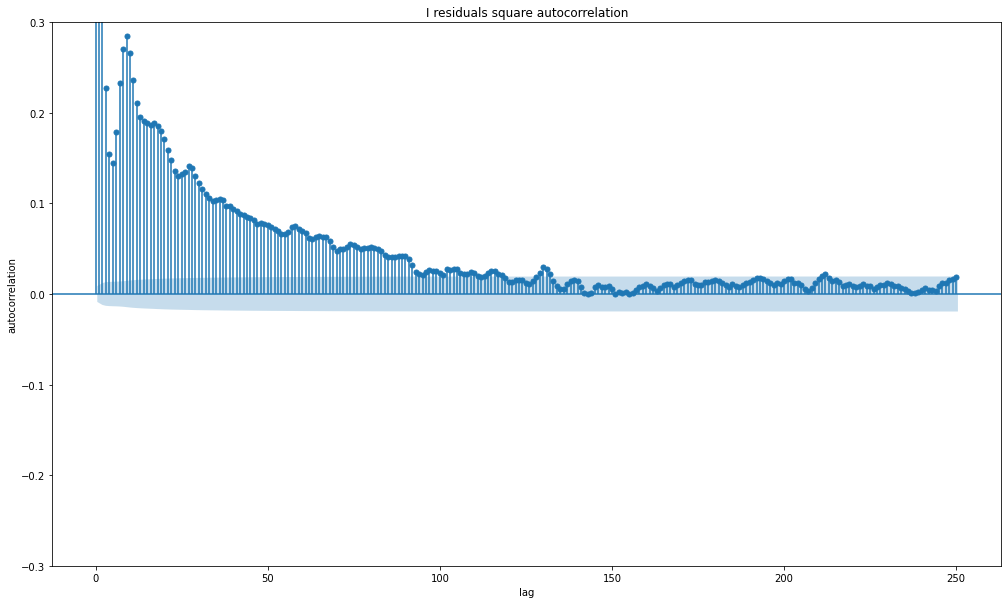

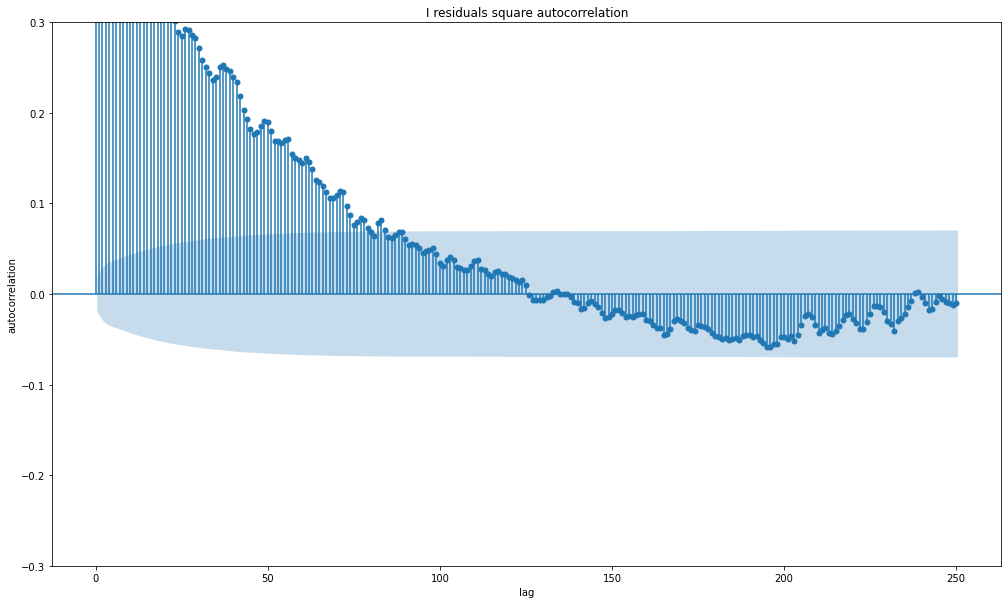

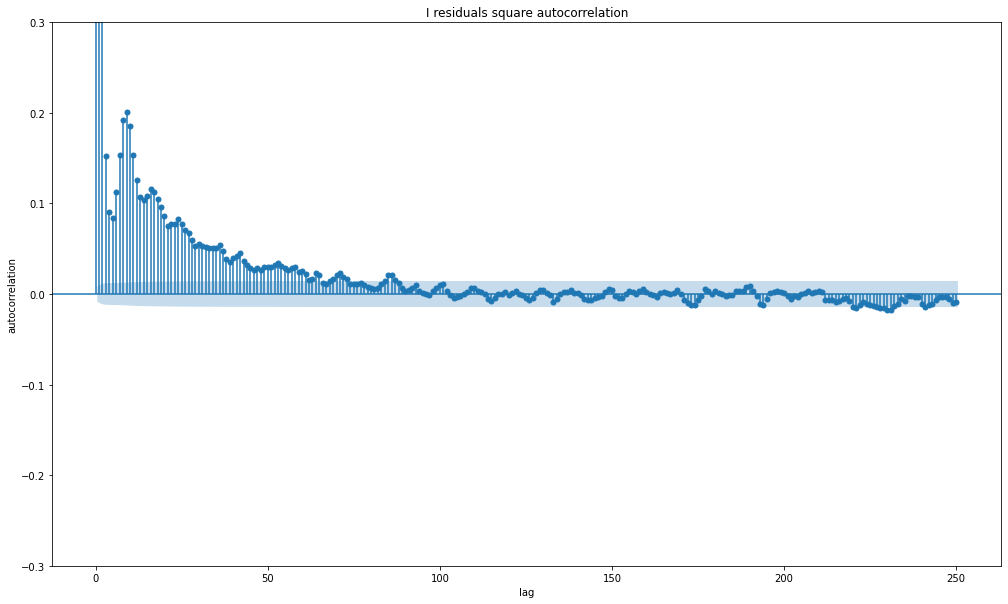

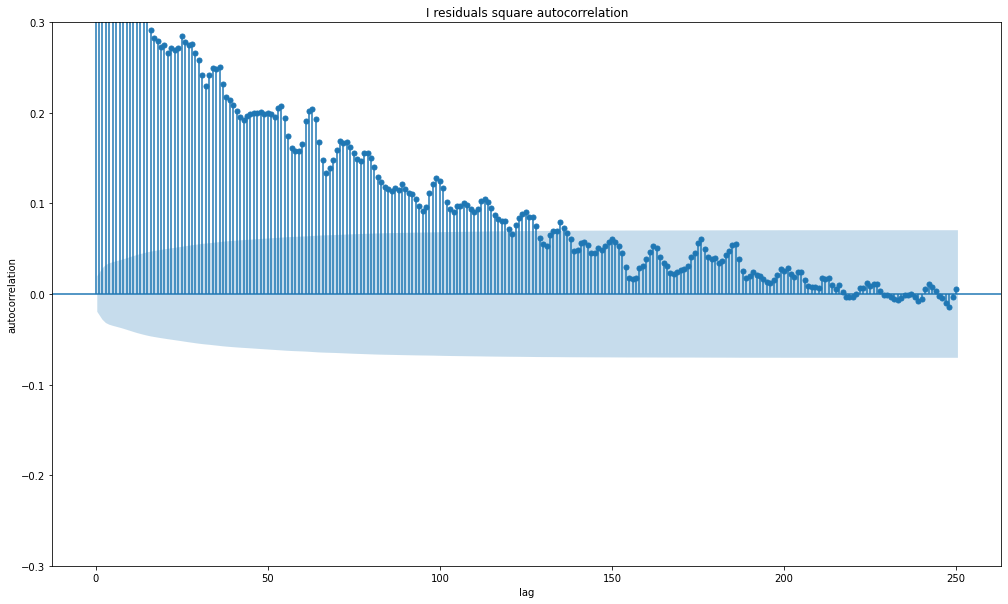

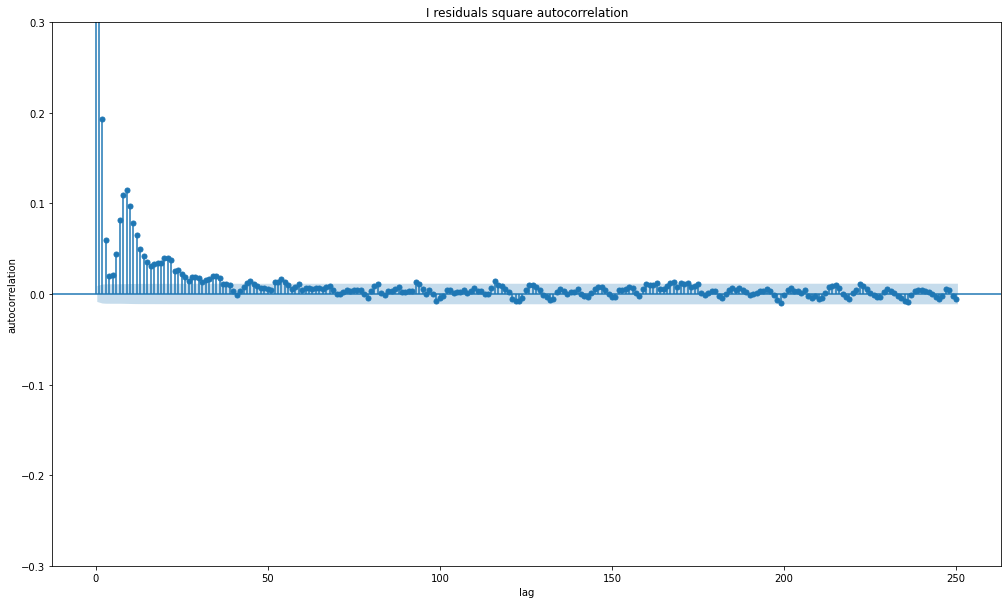

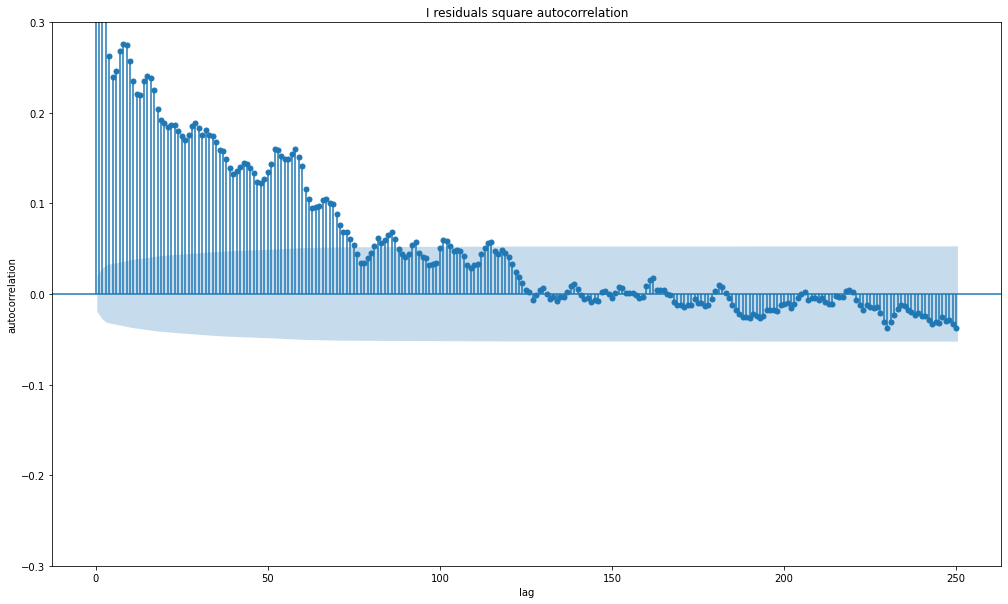

[0. 0. 0. 0. 2. 2. 2. 9. 1. 3. 1. 2.]


In [19]:
print(np.shape(residuals2_largerCurrents_weights[0]))

autocorr_max_lag = 250
autocorr_cut = 0.385
residuals2_autocorr_geq_autocorr_cut = np.zeros(len(index_largerCurrents))

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals2_autocorr,confit = sm.tsa.acf(residuals2_largerCurrents_weights[index_i], nlags = autocorr_max_lag, alpha=0.05)
    residuals2_autocorr_geq_autocorr_cut[index_i] = np.nonzero(np.abs(residuals2_autocorr)>=autocorr_cut)[0][-1] # get the last index with autocorrelation geq to 0.05
    plot_acf(residuals2_largerCurrents_weights[index_i], lags=autocorr_max_lag)
    plt.xlabel('lag')
    plt.ylim([-0.3,0.3])
    plt.ylabel('autocorrelation')
    plt.title('I residuals square autocorrelation')
    fig = plt.gcf()
    fig.set_size_inches(17, 10)
    plt.show()

print(residuals2_autocorr_geq_autocorr_cut)


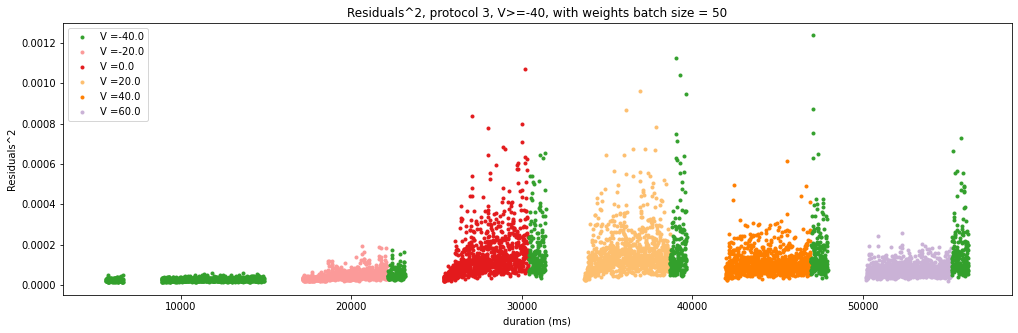

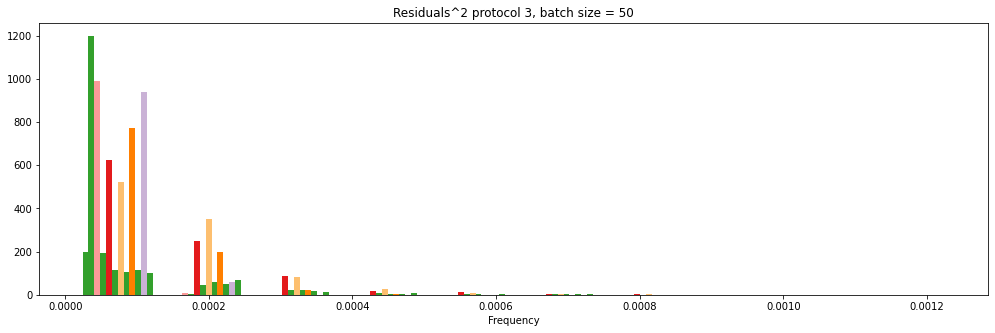

In [123]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 50
remove_at_end_weights = np.zeros(len(residuals2_largerCurrents_weights)).astype(int)
residuals2_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
times_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_meanbatch = [None] * len(index_largerCurrents)

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    remove_at_end_weights[index_i] = len(residuals2_largerCurrents_weights[index_i])%batch_size
    residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    times_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(times_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    currents_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(currents_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights_meanbatch,  color = np.array(pr3_voltage_constV_colors)[index_largerCurrents.astype(int)], label=pr3_voltage_constV_labels_simple[index_largerCurrents.astype(int)])
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, batch size = ' + str(batch_size))
plt.show()




## Scatter plots

Residuals vs: Voltage, Current, and opennes

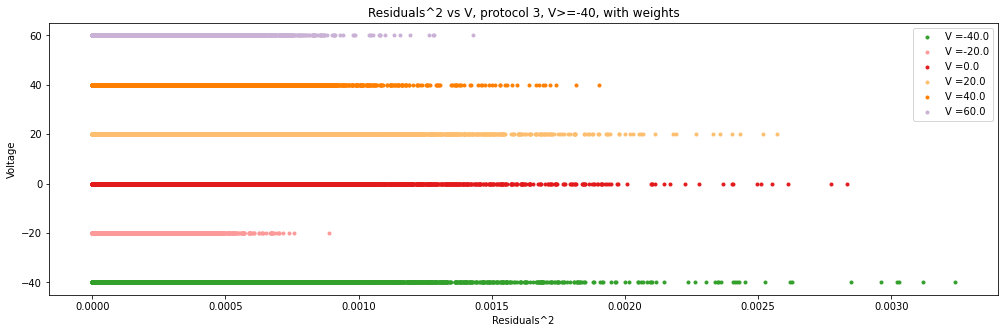

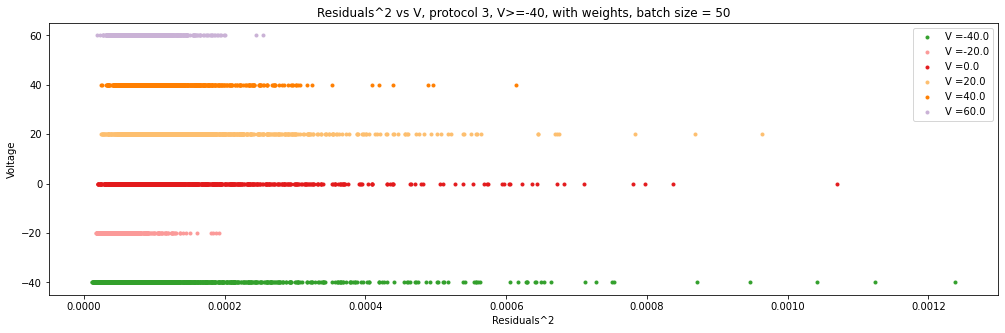

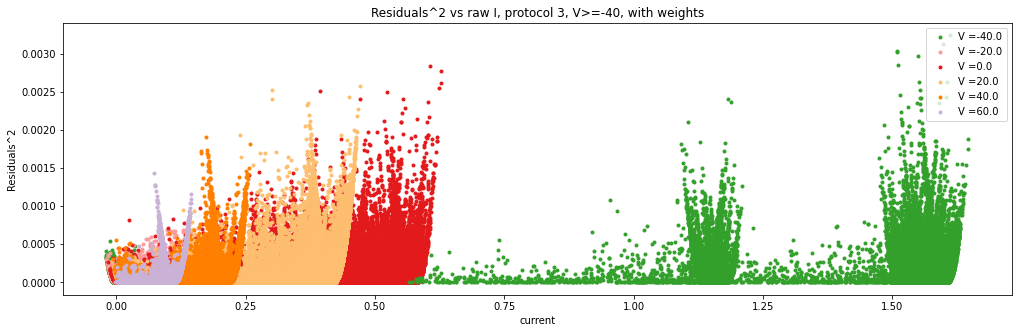

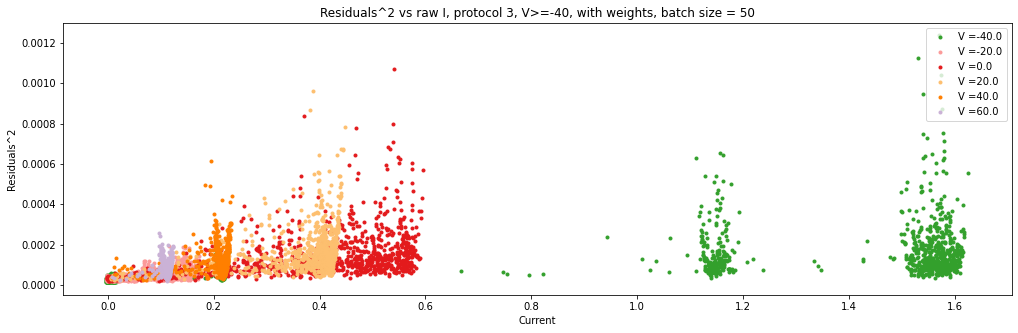

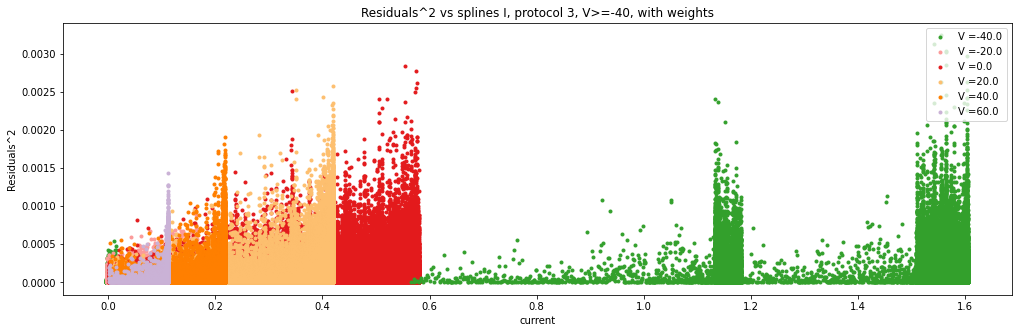

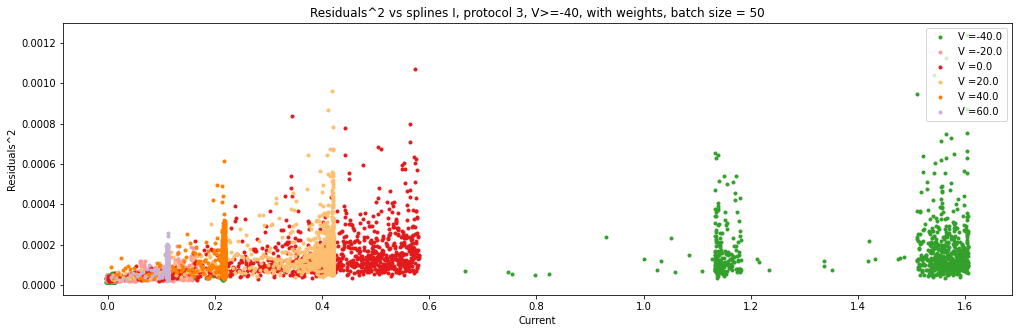

In [124]:

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot( residuals2_largerCurrents_weights[index_i], pr3_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights[index_i])),'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2 vs V, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(residuals2_largerCurrents_weights_meanbatch[index_i], pr3_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights_meanbatch[index_i])), '.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2 vs V, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs raw I, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs raw I, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs splines I, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs splines I, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

## Individual currents (o micro currents)

For micro current:
- Micro current will refer to the indivudual channel current
    - We can get it using i(V) = (V- Ek)*gamma_i
- gamma_i (where gamma_micro is the conductance of an individual channel)
- So the total cell current is I(V) = i(V) * N * O, which is the one we get from the experiments


The parameters:
- Upper and lower bounds for N :  [10,000, 76,000]
- E_k = -85 (from experiments)
- gamma_i =  2e-6  (2 pS -> to uS)
- V depends on the time


In [125]:
# Single channel parameters
N_upper = 76000
N_lower = 10000
Ek = -85
gamma_i = 2e-6# 2 pS -> to uS

# pr3_voltage_constV has the voltages at each step j
indv_current = (pr3_voltage_constV - Ek)*gamma_i 

print(pr3_voltage_constV)
print(indv_current)

[ -80. -120.  -80.  -60.  -40. -120.  -80. -120.  -80.  -40. -120.  -80.
 -120.  -80.  -20.  -40. -120.  -80. -120.  -80.    0.  -40. -120.  -80.
 -120.  -80.   20.  -40. -120.  -80. -120.  -80.   40.  -40. -120.  -80.
 -120.  -80.   60.  -40. -120.  -80.]
[ 1.0e-05 -7.0e-05  1.0e-05  5.0e-05  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05
  1.0e-05  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05  1.3e-04  9.0e-05
 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05  1.7e-04  9.0e-05 -7.0e-05  1.0e-05
 -7.0e-05  1.0e-05  2.1e-04  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05
  2.5e-04  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05  2.9e-04  9.0e-05
 -7.0e-05  1.0e-05]


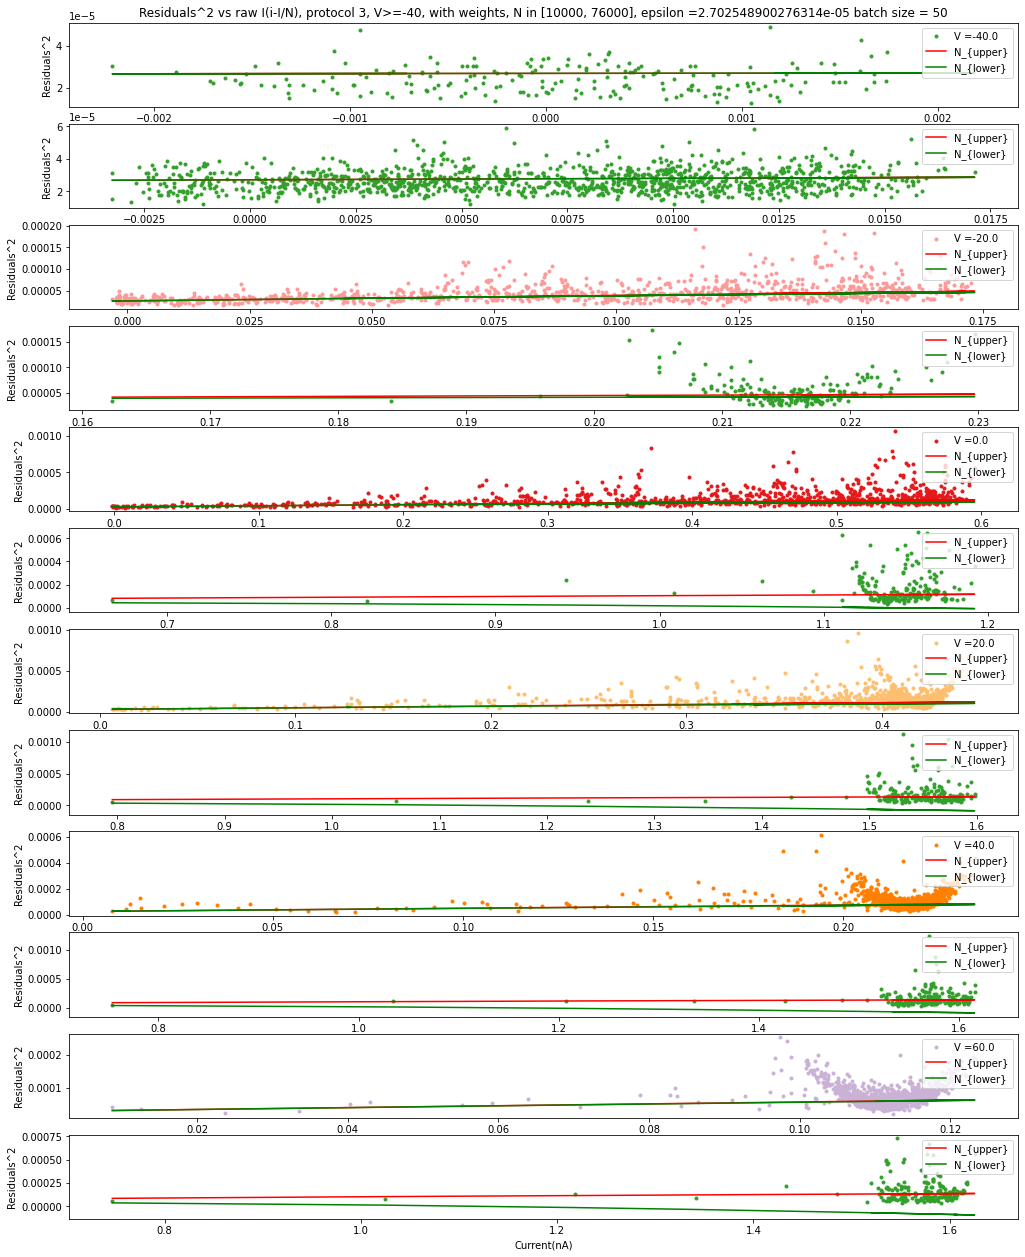

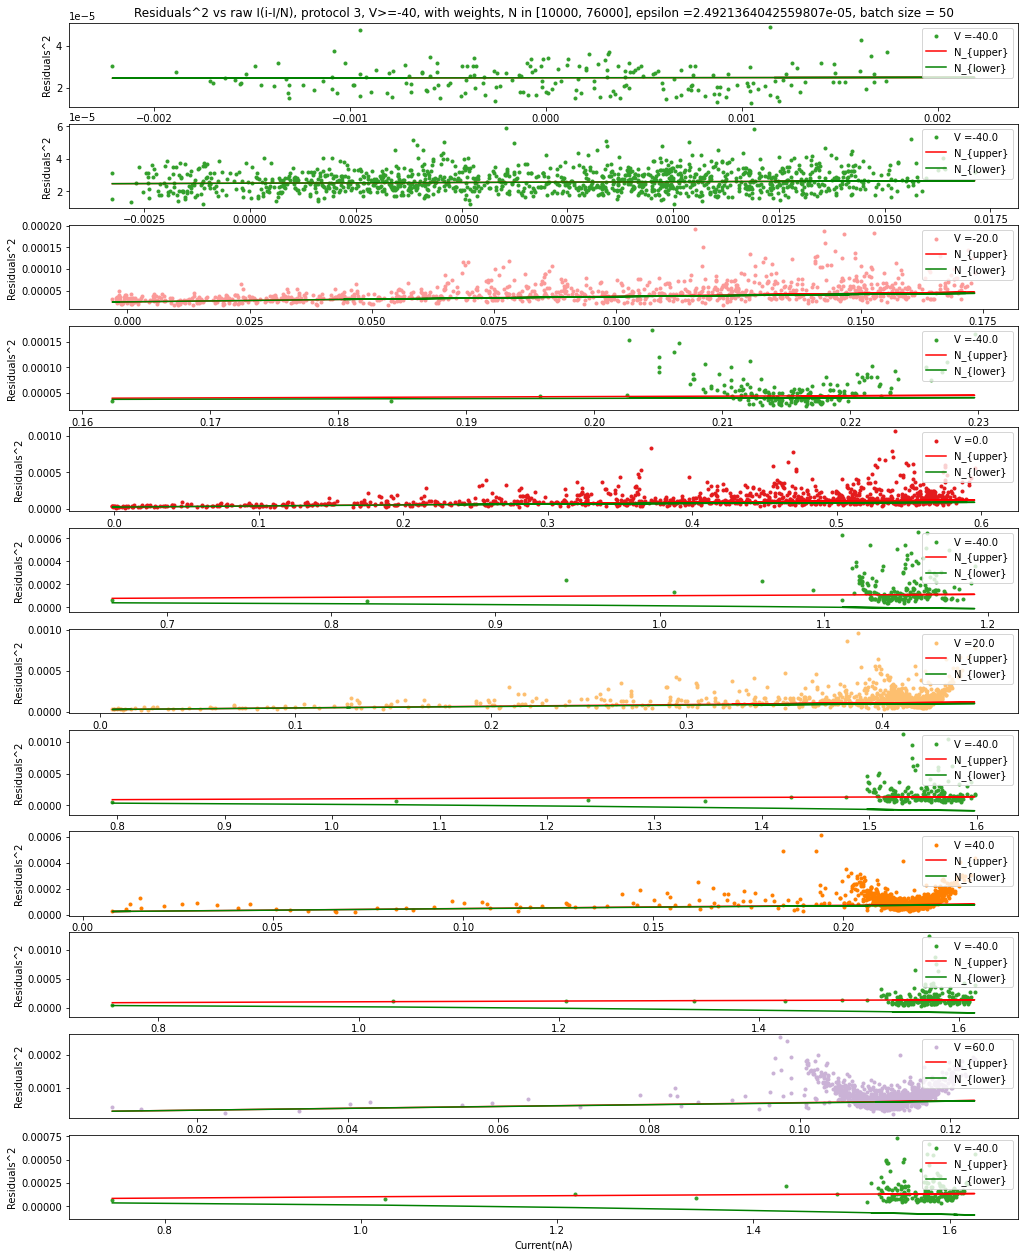

In [126]:
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'r', label=r'N_{upper}')
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'g', label=r'N_{lower}')
    axs[index_i].set_ylabel('Residuals^2')
    axs[index_i].legend(loc='upper right')
    if index_i == 0:
        axs[index_i].set_title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper])+', epsilon ='+str(epsilon1)+' batch size = ' + str(batch_size))
axs[index_i].set_xlabel('Current(nA)')
plt.show()



fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'r', label=r'N_{upper}')
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'g', label=r'N_{lower}')
    axs[index_i].set_ylabel('Residuals^2')
    axs[index_i].legend(loc='upper right')
    if index_i == 0:
        axs[index_i].set_title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper])+', epsilon ='+str(epsilonB)+', batch size = ' + str(batch_size))
axs[index_i].set_xlabel('Current(nA)')
plt.show()

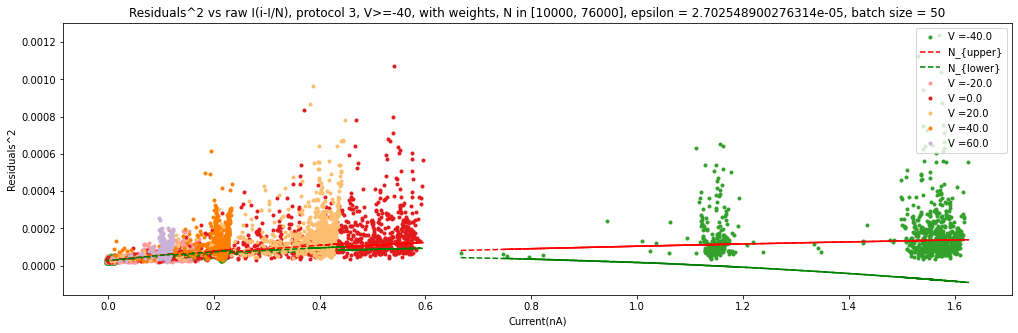

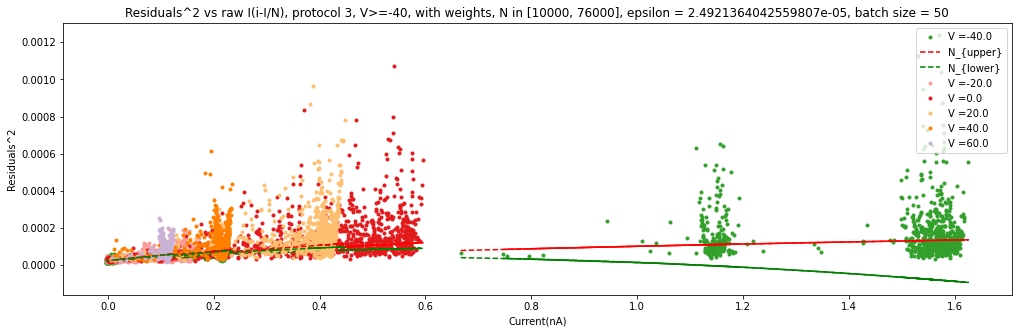

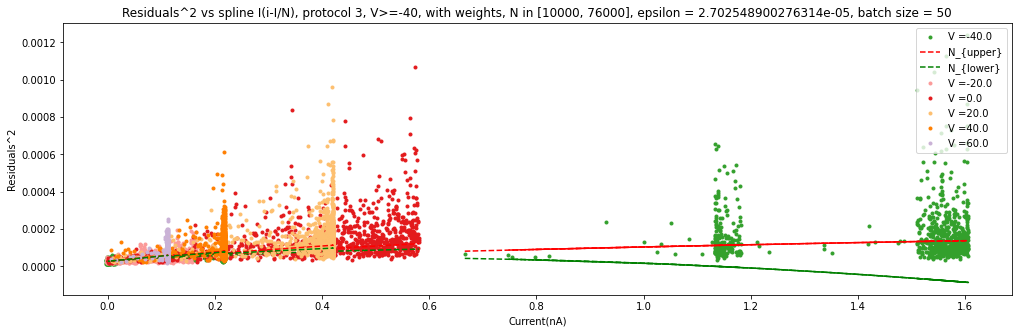

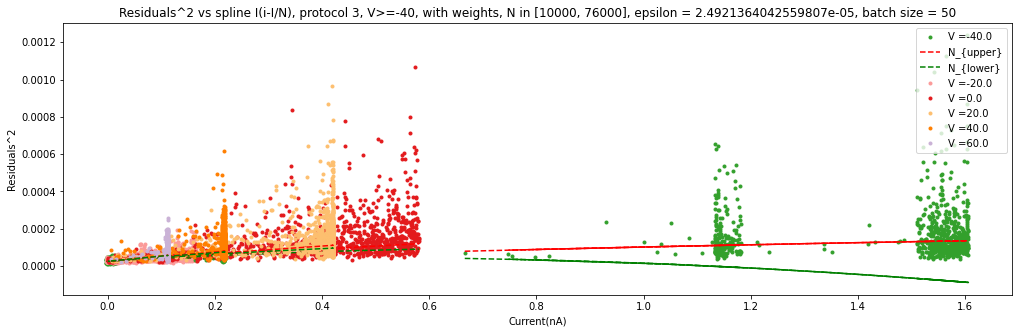

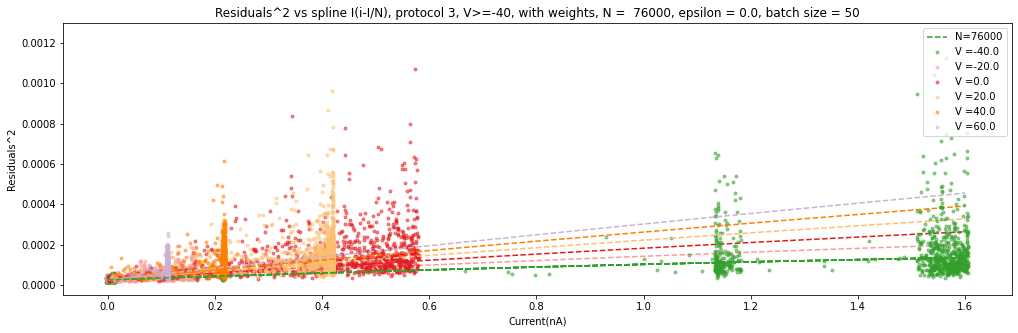

In [127]:
plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilon1)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilonB)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()




plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1 + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1 + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilon1)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilonB)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


current_linspace = np.linspace(0,1.6,20000)


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    if index_i == 0:
        plt.plot(current_linspace, epsilonB + current_linspace * (indv_current[i] - current_linspace/N_upper),'--', color = pr3_voltage_constV_colors[i],  label='N='+str(N_upper))
    else:
        plt.plot(current_linspace, epsilonB + current_linspace * (indv_current[i] - current_linspace/N_upper),'--', color = pr3_voltage_constV_colors[i],  label='_nolegend_')
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', alpha = 0.5, color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N =  '+str(N_upper) + ', epsilon = '+str(round(epsilonB,2))+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()

## Just to double check: linear regresion:

coefficient of determination: 0.0017866086691314953
intercept: 2.43936549464575e-05
slope: [0.00035871]
individual current =  9.999999999999999e-06


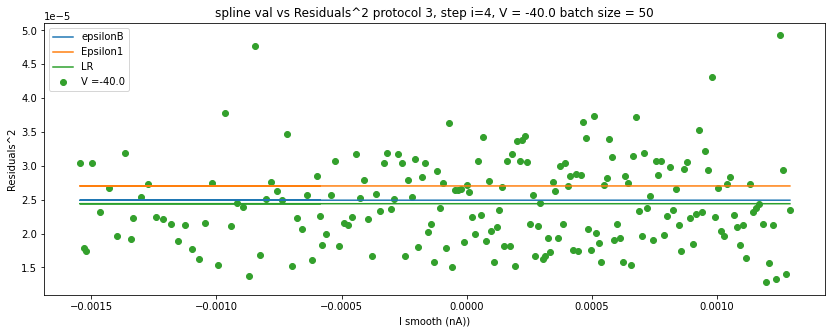

In [128]:
x =  splines_largerCurrents_weights_meanbatch[0].reshape(-1,1)
y = residuals2_largerCurrents_weights_meanbatch[0]
model_LR = LinearRegression()
model_LR.fit(x, y)
r_sq = model_LR.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)

print('individual current = ', indv_current[0])


plt.figure(figsize=(14, 5))
plt.scatter(x, y, color = pr3_voltage_constV_colors[index_largerCurrents[0]], label=pr3_voltage_constV_labels_simple[index_largerCurrents[0]])
plt.plot(x, epsilonB + y * (indv_current[0] - y/N_upper), label = 'epsilonB')
plt.plot(x, epsilon1 + y * (indv_current[0] - y/N_upper), label = 'Epsilon1')
plt.plot(x, model_LR.intercept_ + y * model_LR.coef_, label = 'LR')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(index_largerCurrents[0]) + ', V = '+ str(pr3_voltage[pr3_Vtimes[index_largerCurrents[0]]])+ ' batch size = ' + str(batch_size))


plt.show()

## Openesss

STILL WORK IN PROGRES!!!


For opennes:
- Open is I(V) = N * p_o * (V- Ek)*gamma_i = N * O * i(V), so 
    - N_O = I(V) / ( i(V))

The parameters: (same as for individual currents)
- Upper and lower bounds for N :  [10,000, 76,000]
- E_k = -85 (from experiments)
- gamma_i =  2e-6  (2 pS -> to uS)
- V depends on the time

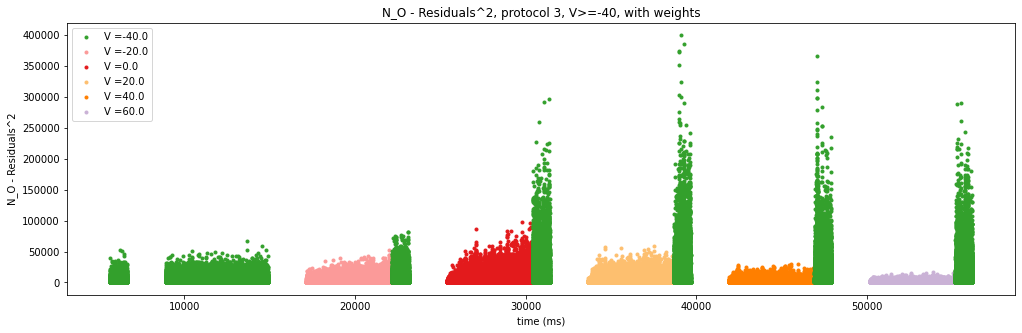

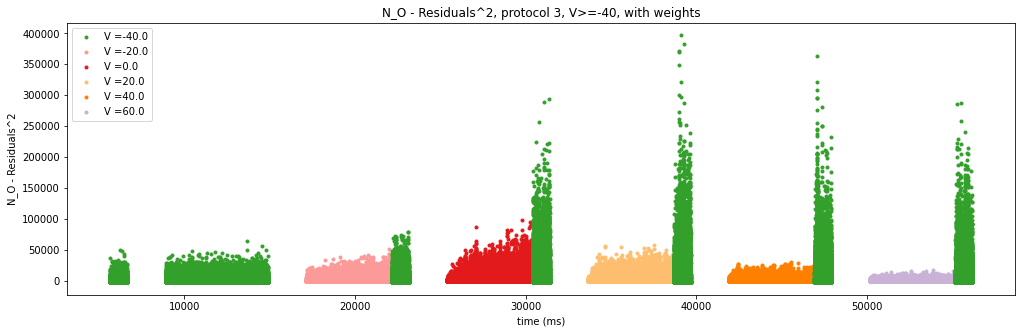

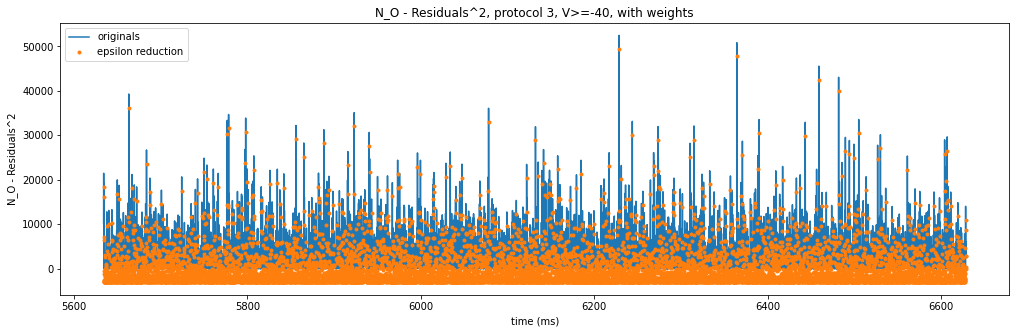

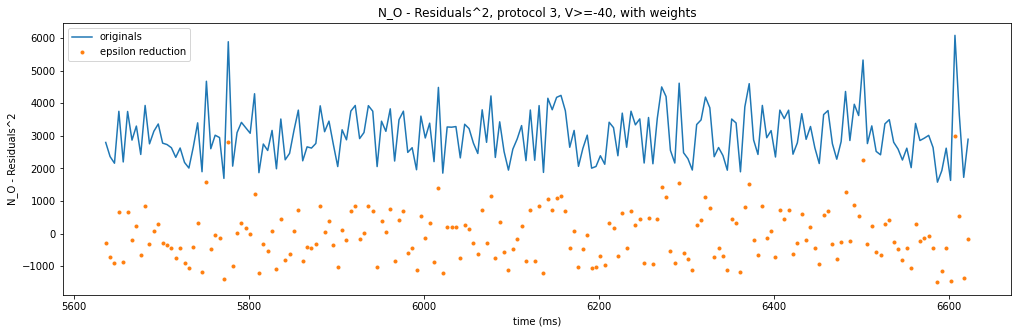

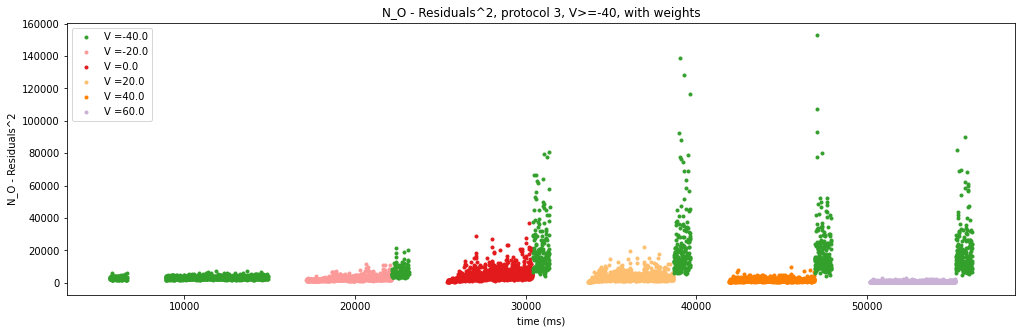

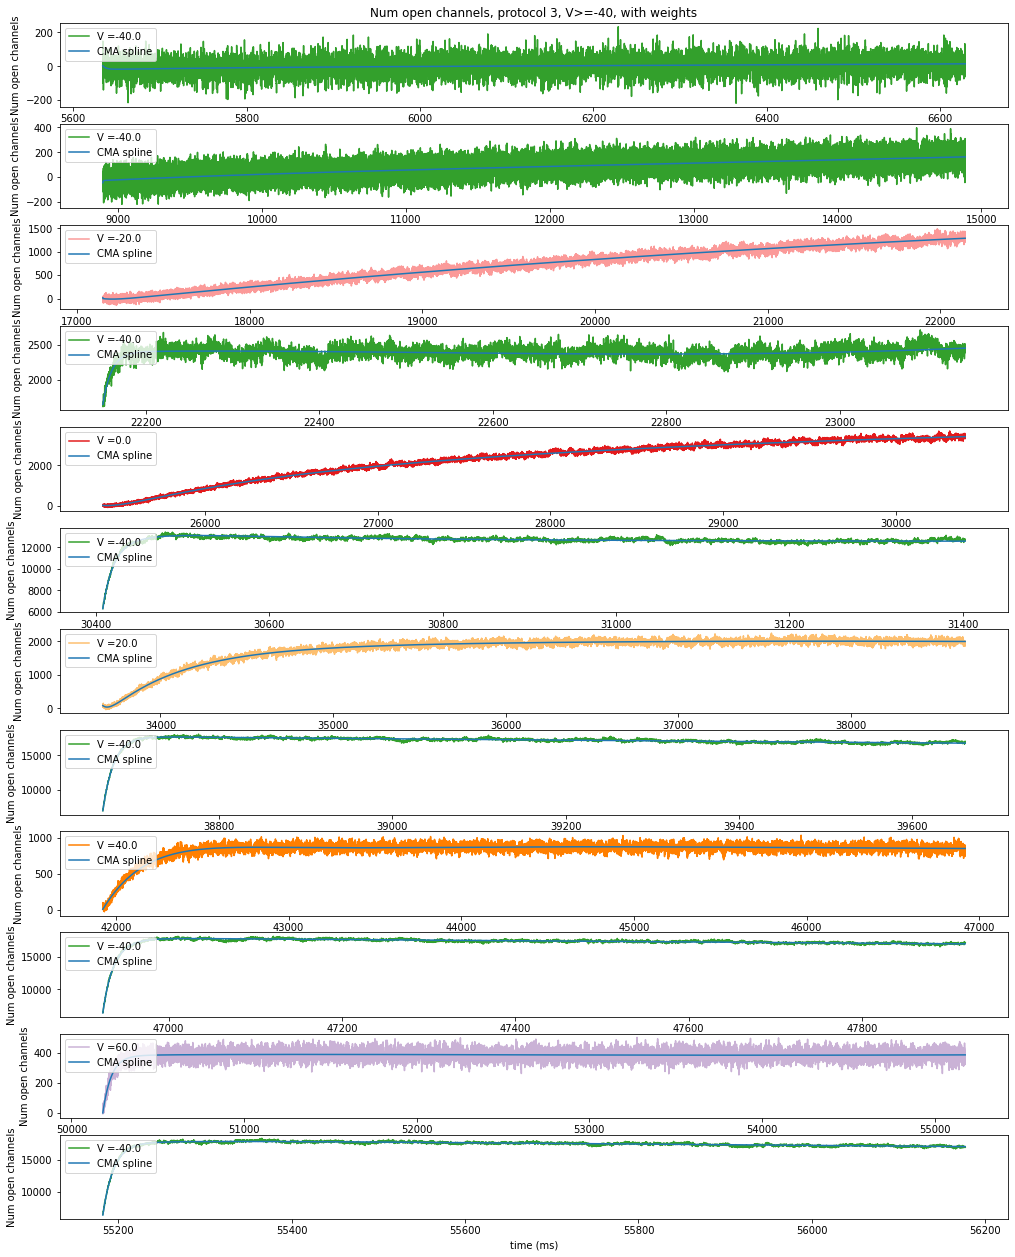

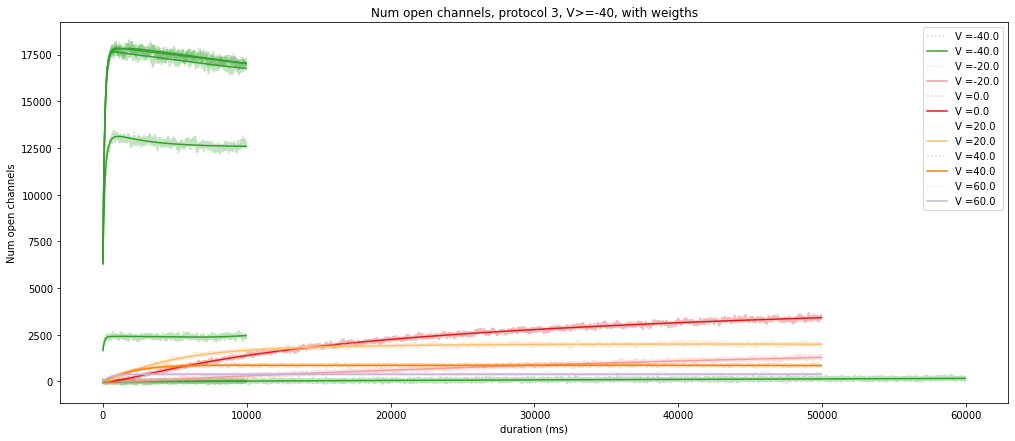

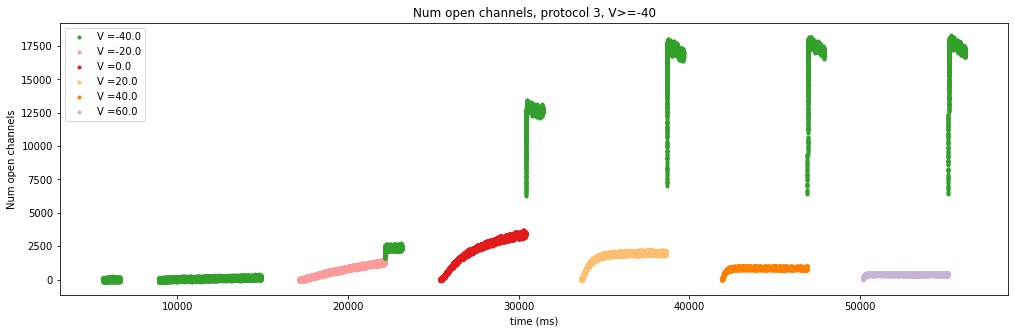

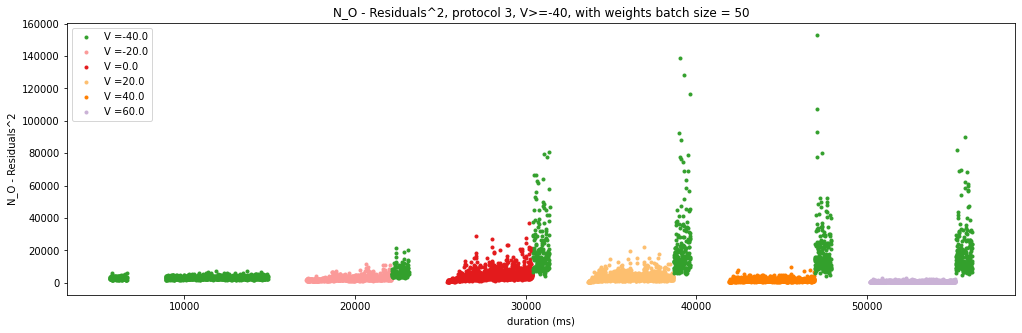

In [129]:
# Raw data
open_largerCurrents = [None] * len(index_largerCurrents)
open_splines_largerCurrents_weights = [None] * len(index_largerCurrents)
open_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)
open_residuals2_simpleConversion_epsilonB_largerCurrents_weights = [None] * len(index_largerCurrents)

# batch data
open_largerCurrents_meanbatch = [None] * len(index_largerCurrents)
open_splines_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
open_residuals2_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)

# Calculate the raw openes, the equivalent spline data and the residuals2

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    # Directly from the formula O = I/(N*i)
    open_largerCurrents[index_i] = (currents_largerCurrents[index_i] - epsilonB) / ( indv_current[i])
    open_splines_largerCurrents_weights[index_i] = (splines_largerCurrents_weights[index_i]-epsilonB) / ( indv_current[i])
    residuals = open_largerCurrents[index_i] - open_splines_largerCurrents_weights[index_i]
    open_residuals2_largerCurrents_weights[index_i] = residuals ** 2
    open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i] = ((residuals2_largerCurrents_weights[index_i]- epsilonB) / indv_current[i]) / indv_current[i]
    # Batch them
    open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(open_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]    
    plt.plot(times_largerCurrents[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
index_i = 0 
i=index_largerCurrents[index_i]   
plt.plot(times_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'-',label = 'originals')
plt.plot(times_largerCurrents[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i],'.', label='epsilon reduction')
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
index_i = 0 
i=index_largerCurrents[index_i]   
plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'-',label = 'originals')
plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch[index_i],'.', label='epsilon reduction')
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], open_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], open_splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Num open channels')
    if index_i == 0:
        axs[index_i].set_title('Num open channels, protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 7))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i],':', color = pr3_voltage_constV_colors[i],alpha = 0.3, label=pr3_voltage_constV_labels_simple[i])
    plt.plot(open_splines_largerCurrents_weights[index_i], color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Num open channels')
plt.title('Num open channels, protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], open_largerCurrents[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Num open channels')
plt.title('Num open channels, protocol 3, V>=-40')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


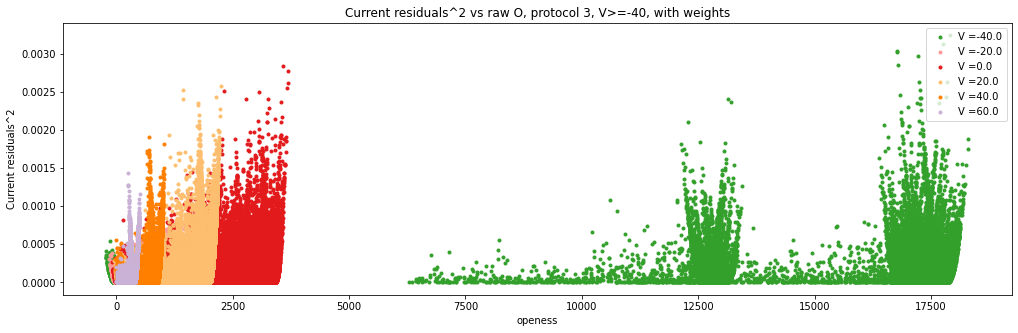

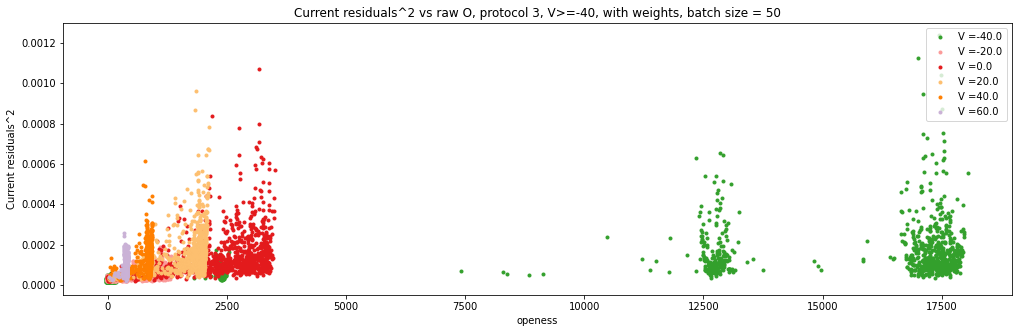

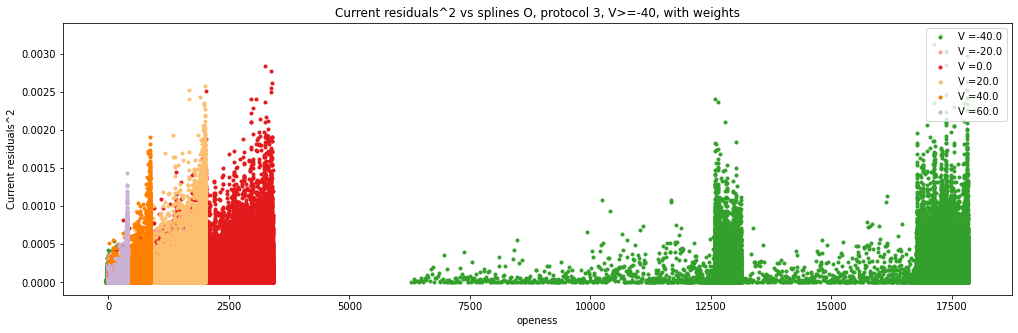

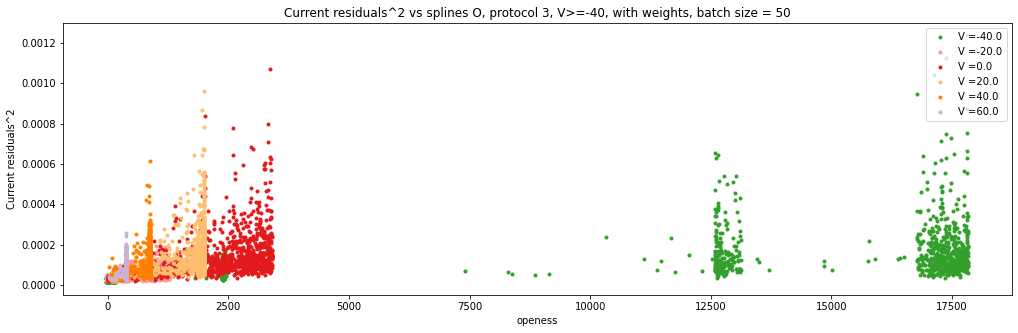

In [130]:
# Rest of the scatter plots comaring to CURRENT RESIDUASL

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs raw O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs raw O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs splines O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

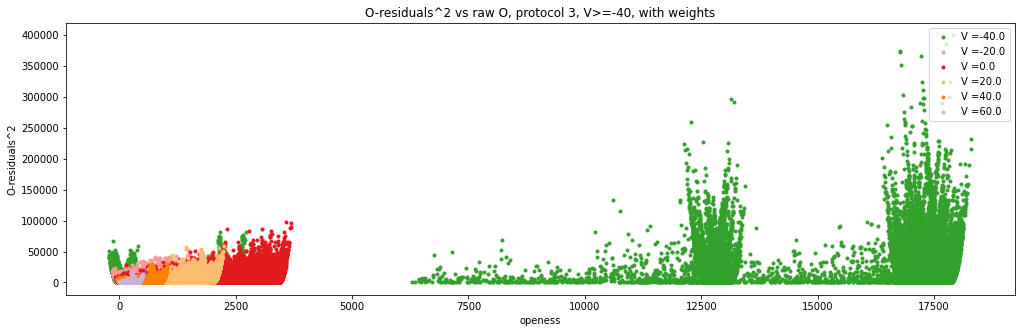

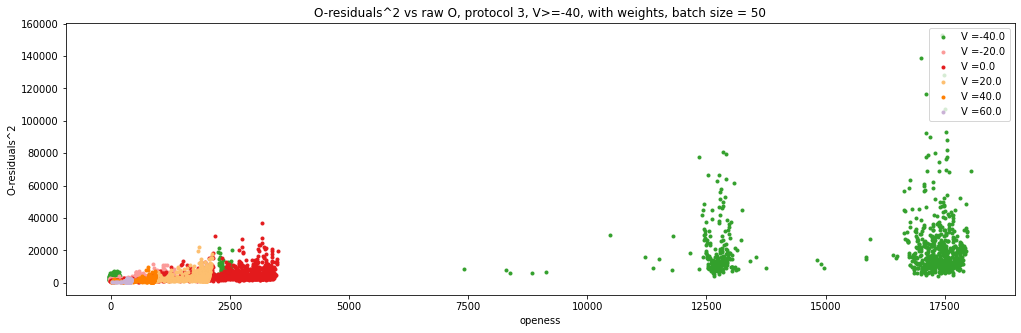

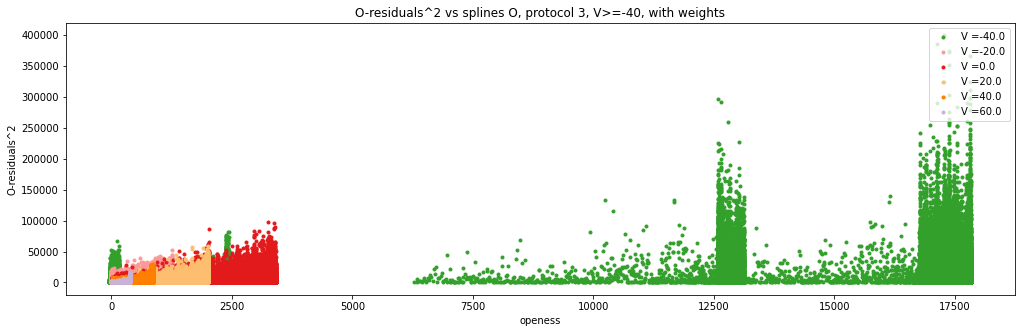

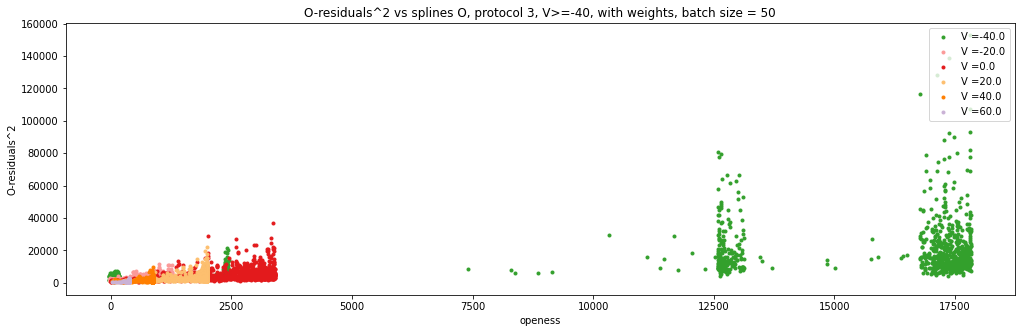

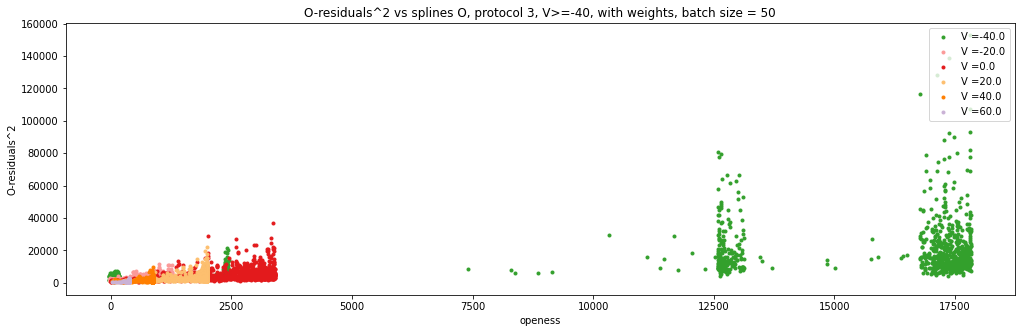

In [132]:
# Open vs open residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs raw O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs raw O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

## Instead of adding epsilon to Open, I removed epsiolon from current
### epsilon for Open

V80_open_means = np.zeros(len(index_neg80))
V80_open_vars = np.zeros(len(index_neg80))
pr3_open_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_open_means[k] = np.mean(pr3_current_constV_without_first5ms[j]/indv_current[j])
    V80_open_vars[k] = np.var(pr3_current_constV_without_first5ms[j]/indv_current[j])
    if np.abs(V80_means[k]) < 0.009:
        pr3_open_constV_80smeanzero =np.append(pr3_open_constV_80smeanzero, pr3_current_constV_without_first5ms[j]/indv_current[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j]/indv_current[j],'.', color = pr3_voltage_constV_colors[j], label='Var='+str(V80_open_vars[k]))
    plt.plot(pr3_time_constV_without_first5ms[j],V80_open_means[k]+np.zeros(len(pr3_time_constV_without_first5ms[j])), color = 'r', label='Mean='+str(V80_open_means[k]))
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr3_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


print([indv_current[j],pr3_current_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j]/indv_current[j]])
print(np.mean(V80_open_vars))
print(np.mean(V80_open_vars[V80_means<0.002]))
print([np.mean(pr3_open_constV_80smeanzero**2),np.var(pr3_open_constV_80smeanzero)])
print(epsilonB/indv_current[0]**2)
print([V80_open_means[4],V80_open_vars[4]])


x= np.mean(np.reshape(pr3_current_constV[0][:-290]/indv_current[0],[-1, batch_size]),axis=1)
print(np.var(x))

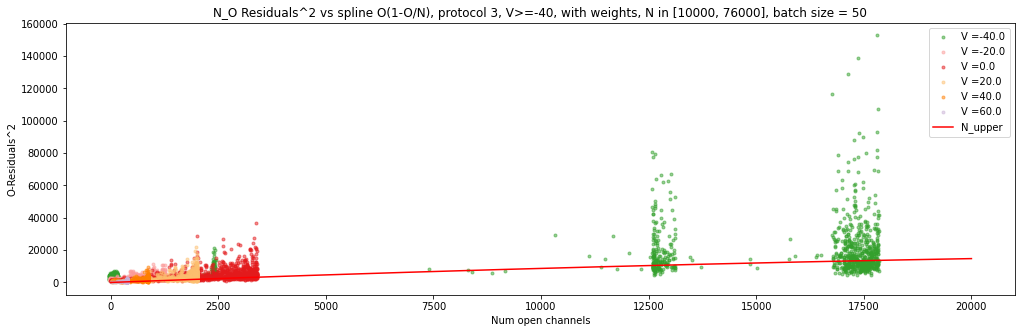

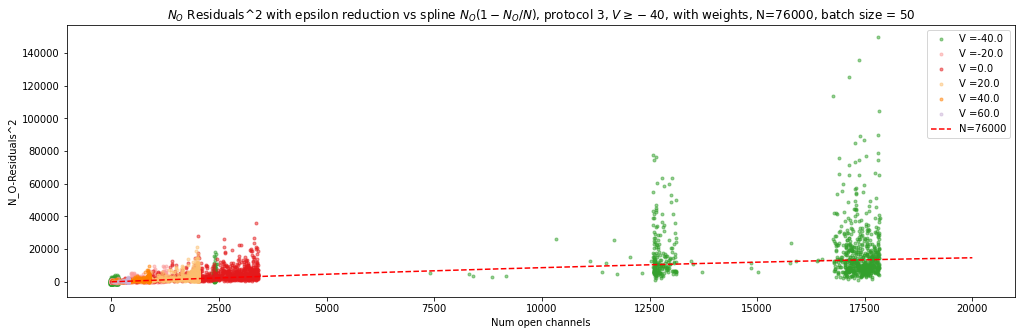

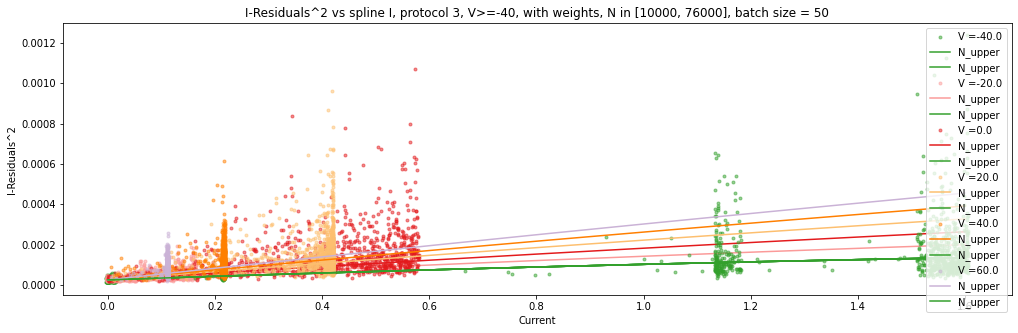

In [133]:
# Open-R^2 versus O(1-O/N)
open_splines_largerCurrents_weights_meanbatch_ALL = np.hstack(open_splines_largerCurrents_weights_meanbatch)
open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL = np.hstack(open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch)



open_linspace = np.linspace(0,20000,20000)

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i],alpha = 0.5, label=pr3_voltage_constV_labels_simple[i])  
plt.plot(open_linspace,   open_linspace * (1 - open_linspace/N_upper),'-r', label='N_upper')
plt.ylabel('O-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title('N_O Residuals^2 vs spline O(1-O/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) +', batch size = ' + str(batch_size))
plt.xlabel('Num open channels')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i],alpha = 0.5, label=pr3_voltage_constV_labels_simple[i])  
plt.plot(open_linspace,   open_linspace * (1 - open_linspace/N_upper),'--r', label='N='+str(N_upper))
#plt.plot(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL,':',alpha = 0.5, label='all')
plt.ylabel('N_O-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title(r'$N_O$ Residuals^2 with epsilon reduction vs spline $N_O(1-N_O/N)$, protocol 3, $V\geq -40$, with weights, N='+str(N_upper) +', batch size = ' + str(batch_size))
plt.xlabel('Num open channels')
plt.show()



current_linspace = np.linspace(0,1.6,20000)

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i],alpha = 0.5, label=pr3_voltage_constV_labels_simple[i])  
    plt.plot(current_linspace, epsilonB + current_linspace * (indv_current[i] - current_linspace/N_upper), color = pr3_voltage_constV_colors[i], label='N_upper')
#plt.plot(open_linspace, np.var(x) + open_linspace * (1 - open_linspace/N_lower),'-g', label='N_lower')
plt.ylabel('I-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title('I-Residuals^2 vs spline I, protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) +', batch size = ' + str(batch_size))
plt.xlabel('Current')
plt.show()

## Test a linear and a quadratic fit to open data

- Need to transform all the residuals and spline fits into two large arrays to use as inputs for the fit: DONE andd added in cell above
- Doing the linear regresion will be easy
- Find out how to do quadratic regresion


Linear regression
coefficient of determination: 0.4329634168602716
intercept: 634.3668173585638
slope: [1.0820885]
Quadratic regression
            2
-4.779e-05 x + 1.901 x - 71.38
[-2.51355303e-05  1.00000000e+00 -3.75429759e+01]
N_1 =  20923.74738444389
N_2 =  39784.320718788964
Direct estimation of N from quadratic form: x*(1-x/N), N =  [328678.38758776]


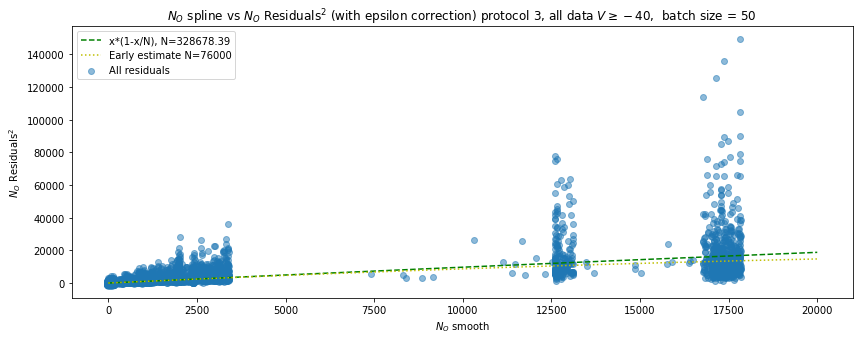

In [134]:
open_linspace = np.linspace(0,20000,20000)

model_LR = LinearRegression()
model_LR.fit(open_splines_largerCurrents_weights_meanbatch_ALL.reshape(-1, 1), open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL)
r_sq = model_LR.score(open_splines_largerCurrents_weights_meanbatch_ALL.reshape(-1, 1), open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL)
print('Linear regression')
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)


#polynomial fit with degree = 2
model_QR = np.poly1d(np.polyfit(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL, 2))
print('Quadratic regression')
print(model_QR)
print(model_QR.coefficients/model_QR.coefficients[1])
print('N_1 = ', -1/model_QR.coefficients[0])
print('N_2 = ', -model_QR.coefficients[1]/model_QR.coefficients[0])

# Fit to function x*(1-x/N)
N0_fit = N_upper


#bounds_cma = [[0, None]]
#optscma = cma.CMAOptions()
#optscma.set("bounds", bounds_cma)
## CMA fit Quadratic_fit_for_N(N, x, data) (x * (1 - x / N))
#es = cma.fmin(Quadratic_fit_for_N, N0_fit , sigma0=1, args=[open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL], options = optscma)
#es = minimize_scalar(Quadratic_fit_for_N, bounds=[0, None], args=(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL))
es = minimize(Quadratic_fit_for_N, N0_fit, args = (open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL), bounds=((0, None),))

N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL = es.x
print('Direct estimation of N from quadratic form: x*(1-x/N), N = ', N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL)

plt.figure(figsize=(14, 5))
plt.scatter(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL,  alpha =0.5, label='All residuals')
#plt.plot(open_linspace, model_LR.intercept_ + open_linspace * model_LR.coef_, label = 'LR: '+ str(round(model_LR.coef_[0],2)) + 'x + ' + str(round(model_LR.intercept_,2)))
#plt.plot(open_linspace, model_QR(open_linspace),'--b', label = 'QR: ' + str(round(model_QR.coefficients[0],7)) + r'$x^2$ + ' + str(round(model_QR.coefficients[1],2)) + 'x + ' + str(round(model_QR.coefficients[2],2)))
plt.plot(open_linspace, open_linspace * (1 - open_linspace / N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL),'--g', label = 'x*(1-x/N), N='+str(round(N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL[0],2)))
#plt.plot(open_linspace, open_linspace * (1- open_linspace / N_upper) + (model_QR.coefficients[1]-1) * open_linspace + model_QR.coefficients[2] ,':',color ='paleturquoise', label = 'QR with - a^-1 = N='+str(N_upper))
#plt.plot(open_linspace, model_QR.coefficients[1] * open_linspace * (1- open_linspace / N_upper)  + model_QR.coefficients[2] ,':c', label = 'QR with - ba^-1 = N='+str(N_upper))
plt.plot(open_linspace,  open_linspace * (1- open_linspace / N_upper) ,':y', label = 'Early estimate N='+str(N_upper))

plt.xlabel(r'$N_O$ smooth')
plt.ylabel(r'$N_O$ Residuals$^2$')
plt.legend(loc='upper left')
plt.title(r'$N_O$ spline vs $N_O$ Residuals$^2$ (with epsilon correction) protocol 3, all data $V\geq -40$,  batch size = ' + str(batch_size))


plt.show()

# Binning by current

[9948, 9949]
[59943, 59949]
[49947, 49949]
[9916, 9949]
[49947, 49949]
[9946, 9949]
[49936, 49949]
[9947, 9949]
[49946, 49949]
[9941, 9949]
[49903, 49949]
[9944, 9949]


/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 1224x360 with 0 Axes>

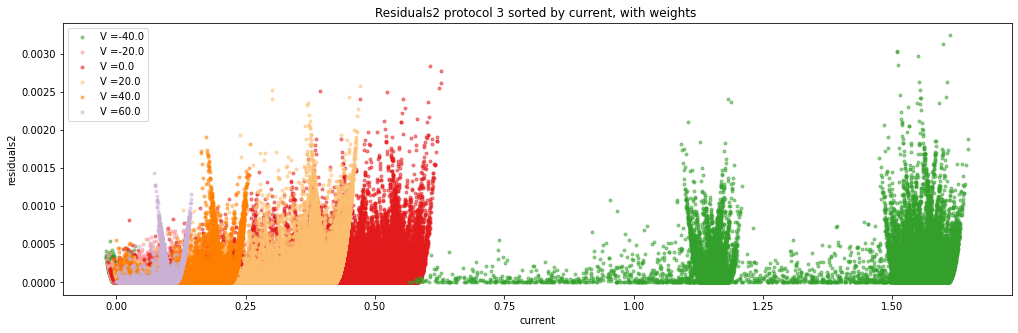

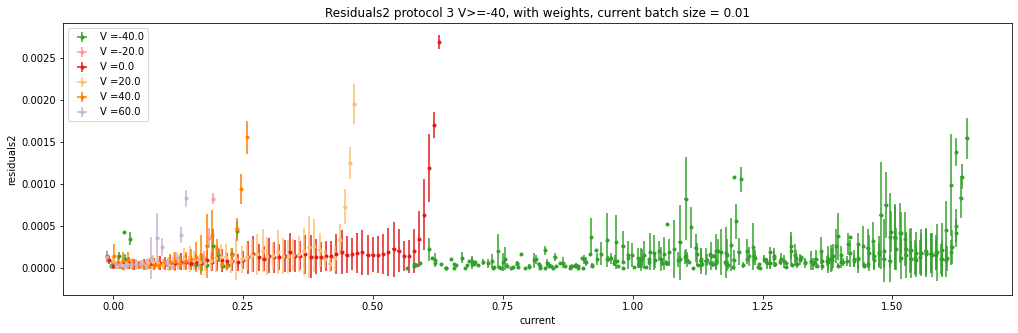

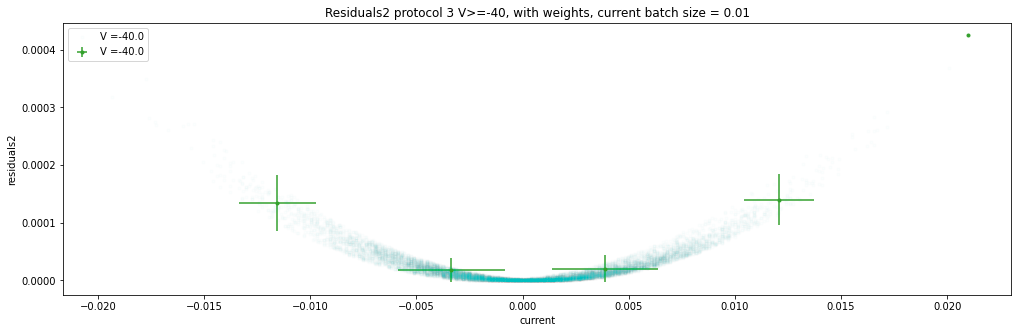

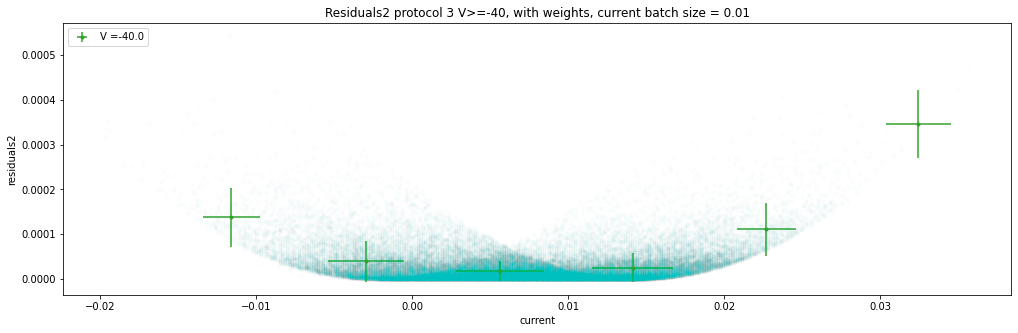

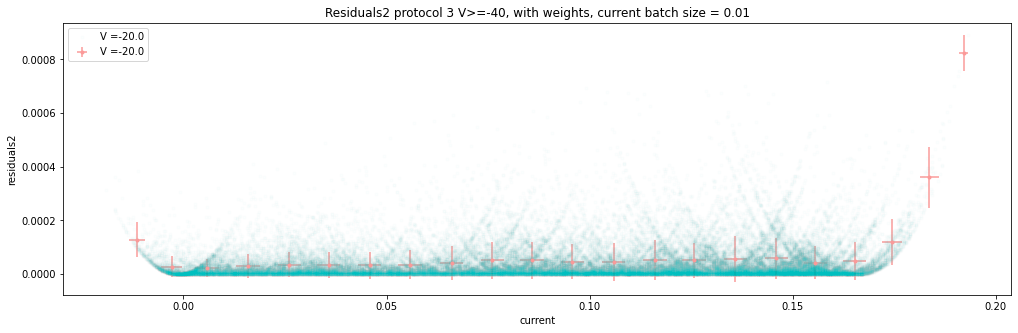

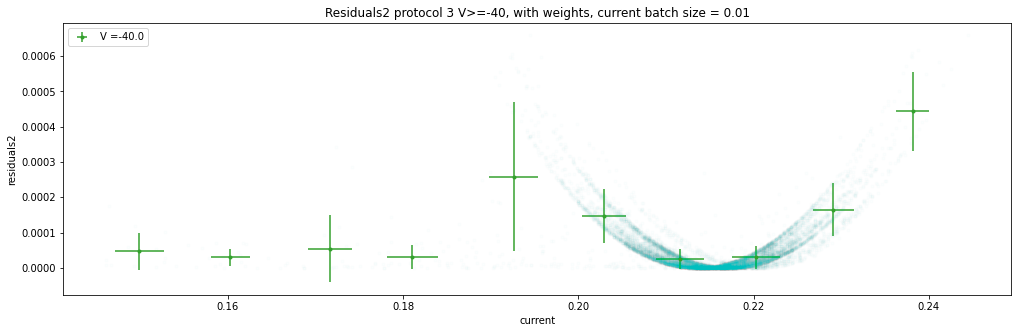

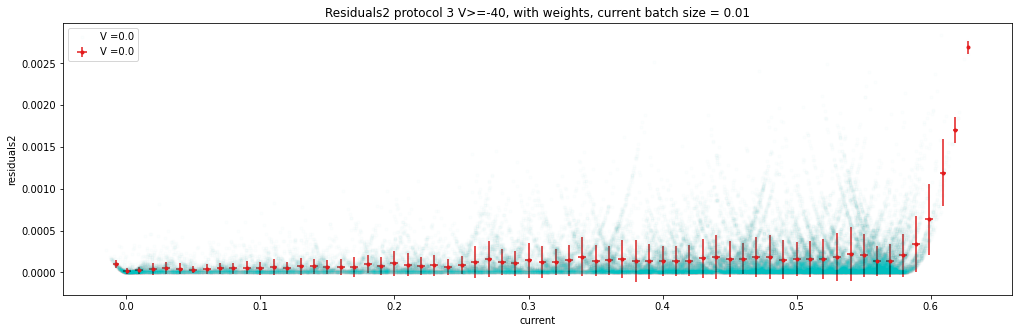

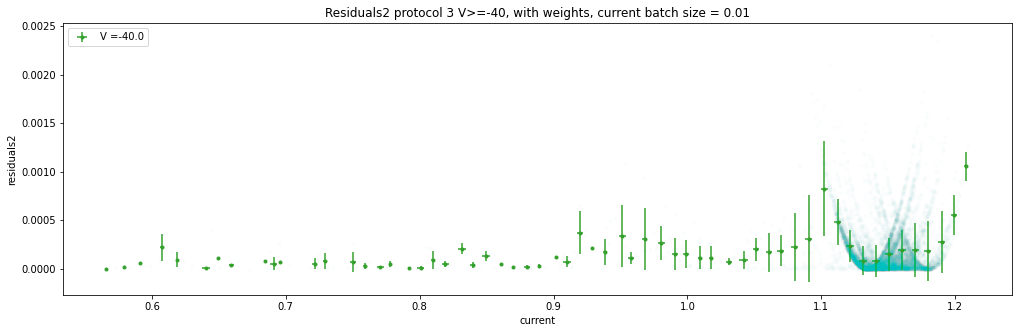

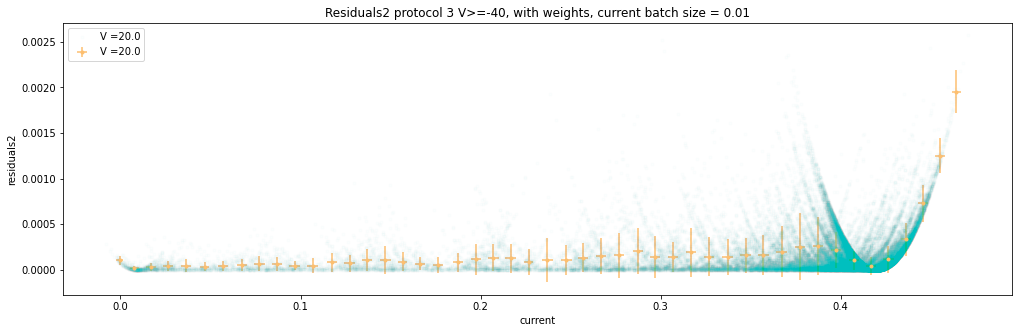

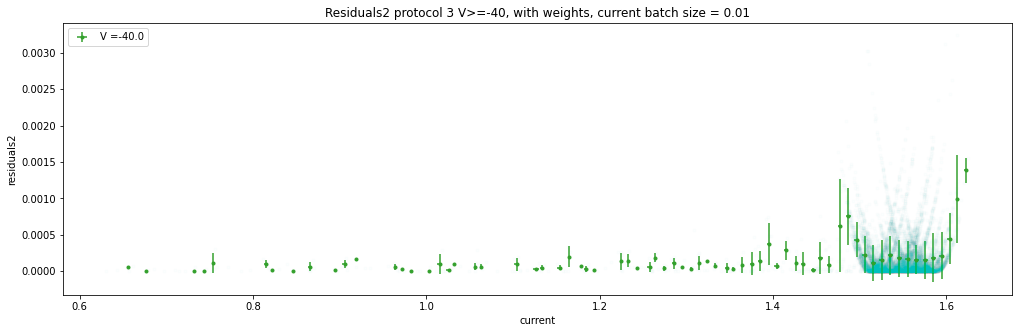

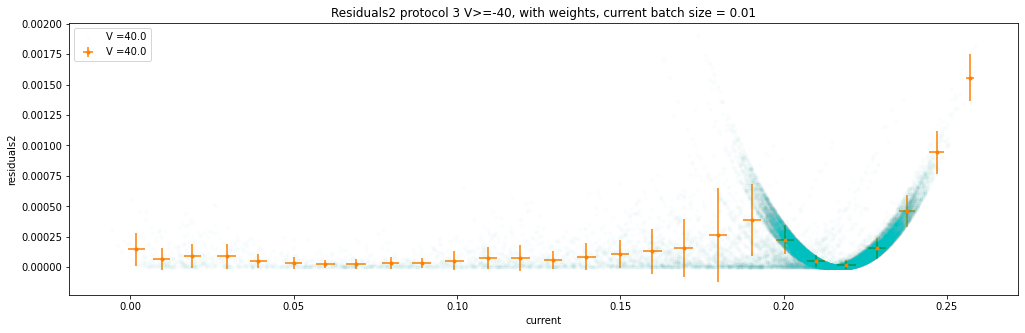

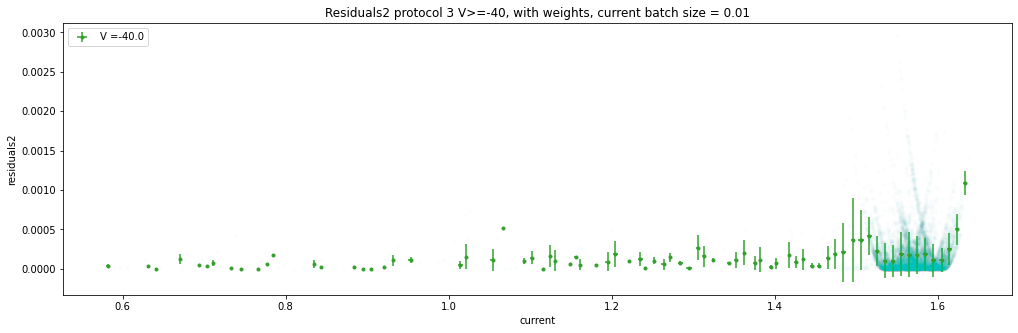

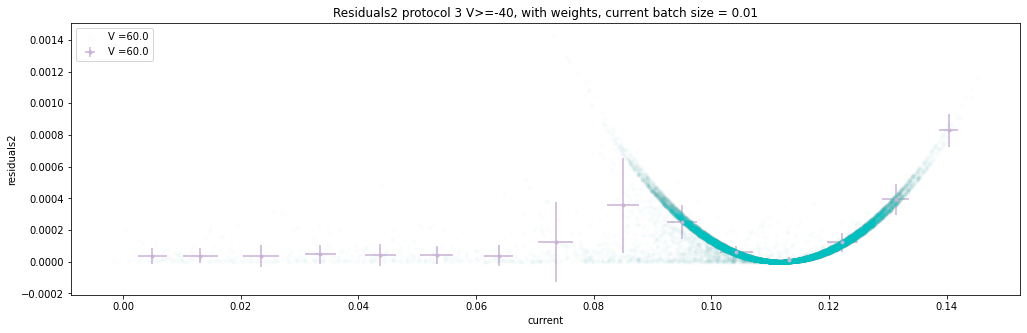

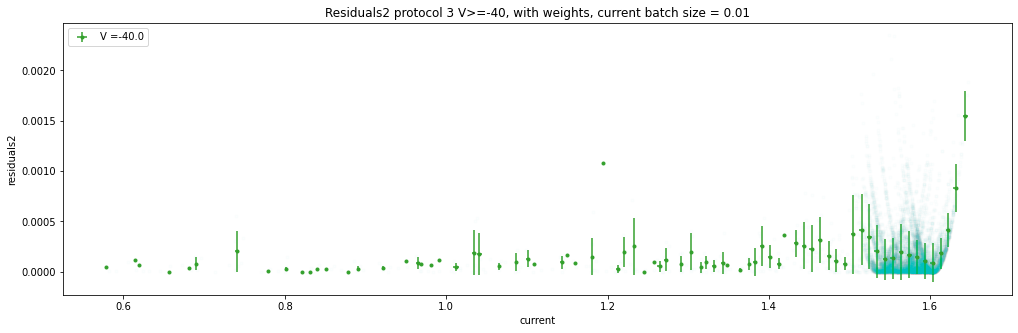

In [135]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
current_batch_size  = 0.01

residuals2_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
times_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_bycurrent = [None] * len(index_largerCurrents)
currents_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
currents_largerCurrents_bycurrent_SORTindex = [None] * len(index_largerCurrents)

residuals2_largerCurrents_weights_bycurrent_meanbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_bycurrent_meanbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)

residuals2_largerCurrents_weights_bycurrent_stdbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_bycurrent_stdbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    # find the index to surt the current
    currents_largerCurrents_bycurrent_SORTindex[index_i] = np.argsort(currents_largerCurrents[index_i])
    # arrange the vectors by current sort
    currents_largerCurrents_bycurrent[index_i] = currents_largerCurrents[index_i][currents_largerCurrents_bycurrent_SORTindex[index_i]]
    times_largerCurrents_weights_bycurrent[index_i] = times_largerCurrents[index_i][currents_largerCurrents_bycurrent_SORTindex[index_i]]
    residuals2_largerCurrents_weights_bycurrent[index_i] = residuals2_largerCurrents_weights[index_i][currents_largerCurrents_bycurrent_SORTindex[index_i]]
    splines_largerCurrents_weights_bycurrent[index_i] = splines_largerCurrents_weights[index_i][currents_largerCurrents_bycurrent_SORTindex[index_i]]
    # BATCHING:
    current_batches = np.arange(currents_largerCurrents_bycurrent[index_i][0],currents_largerCurrents_bycurrent[index_i][-1],current_batch_size)
    last_current_in_batch = np.zeros(len(current_batches)).astype(int)
    residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    splines_largerCurrents_weights_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    currents_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    splines_largerCurrents_weights_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    currents_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    for i in range(len(current_batches)-1):
        last_current_in_batch[i+1] = np.argmax(currents_largerCurrents_bycurrent[index_i]>current_batches[i+1])
        residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i][i] = np.mean(residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
        splines_largerCurrents_weights_bycurrent_meanbatch[index_i][i] = np.mean(splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
        currents_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(currents_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
        residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i][i] = np.std(residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
        splines_largerCurrents_weights_bycurrent_stdbatch[index_i][i] = np.std(splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
        currents_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(currents_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
    residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i][-1] = np.mean(residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[-1]:])
    print([last_current_in_batch[-1], len(residuals2_largerCurrents_weights_bycurrent[index_i])])
    splines_largerCurrents_weights_bycurrent_meanbatch[index_i][-1] = np.mean(splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[-1]:])
    currents_largerCurrents_bycurrent_meanbatch[index_i][-1] = np.mean(currents_largerCurrents_bycurrent[index_i][last_current_in_batch[-1]:])
    residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i][-1] = np.std(residuals2_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[-1]:])
    splines_largerCurrents_weights_bycurrent_stdbatch[index_i][-1] = np.std(splines_largerCurrents_weights_bycurrent[index_i][last_current_in_batch[-1]:])
    currents_largerCurrents_bycurrent_stdbatch[index_i][-1] = np.std(currents_largerCurrents_bycurrent[index_i][last_current_in_batch[-1]:])




plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_bycurrent[index_i],residuals2_largerCurrents_weights_bycurrent[index_i], '.', color = pr3_voltage_constV_colors[i], alpha = 0.5, label = pr3_voltage_constV_labels_simple[i])
    #plt.plot(np.arange(currents_largerCurrents_bycurrent[index_i][0],currents_largerCurrents_bycurrent[index_i][-1],current_batch_size),residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], 'r.', alpha=0.5,label='_nolegend_')
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 protocol 3 sorted by current, with weights ')
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    #plt.plot(currents_largerCurrents_bycurrent[index_i],residuals2_largerCurrents_weights_bycurrent[index_i], '.', color = pr3_voltage_constV_colors[i],alpha=0.5,label='by current')
    #plt.plot(currents_largerCurrents_bycurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i], '.', color = pr3_voltage_constV_colors[i], alpha = 0.5, label = pr3_voltage_constV_labels_simple[i])
    #plt.plot(currents_largerCurrents_bycurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i] + residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], 'c',  alpha = 0.5, label = pr3_voltage_constV_labels_simple[i])
    plt.errorbar(currents_largerCurrents_bycurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i],xerr=currents_largerCurrents_bycurrent_stdbatch[index_i], yerr=residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()




for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.figure(figsize=(17, 5))
    plt.plot(currents_largerCurrents_bycurrent[index_i],residuals2_largerCurrents_weights_bycurrent[index_i], 'c.',  alpha = 0.01, label = pr3_voltage_constV_labels_simple[i])
    plt.errorbar(currents_largerCurrents_bycurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bycurrent_meanbatch[index_i],xerr=currents_largerCurrents_bycurrent_stdbatch[index_i], yerr=residuals2_largerCurrents_weights_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


# Binning by current and time

Take the data that was binned by time and use that to do the binning by current, 

The test is with small time bin size: 50 time points

[0, []]
[1, [2]]
[2, []]
[3, [1]]
[4, []]
[5, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 43]]
[6, [44]]
[7, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69]]
[8, []]
[9, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74]]
[10, []]
[11, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 69,

<Figure size 1224x360 with 0 Axes>

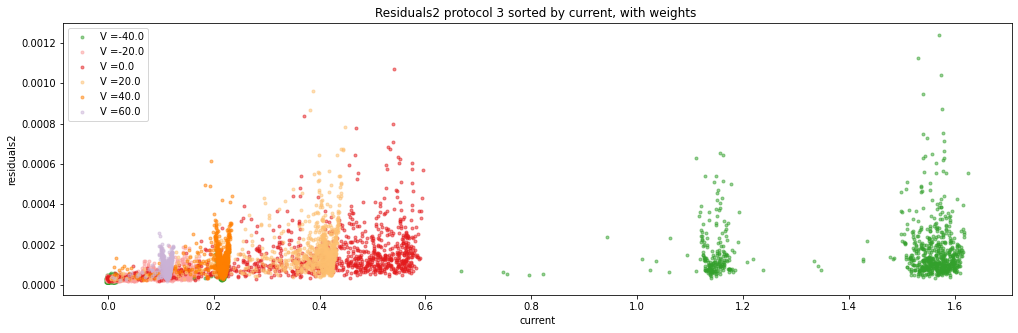

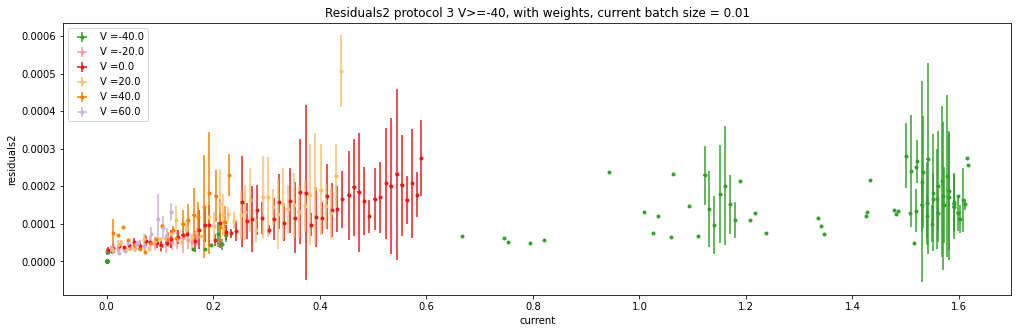

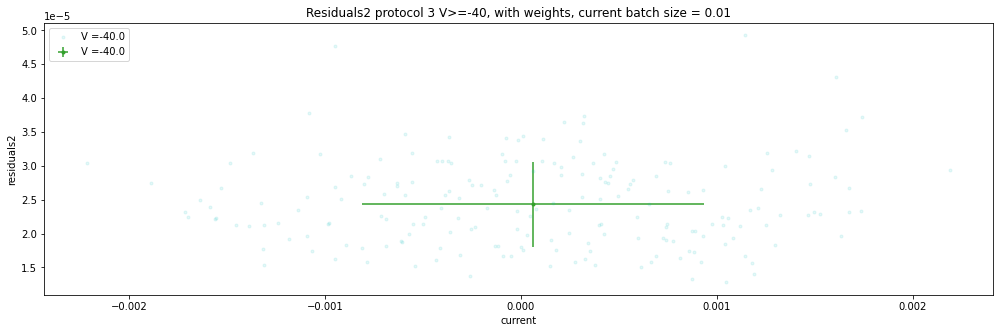

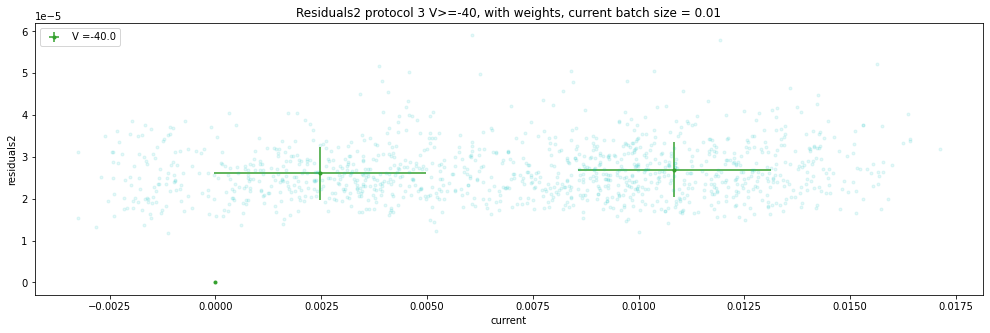

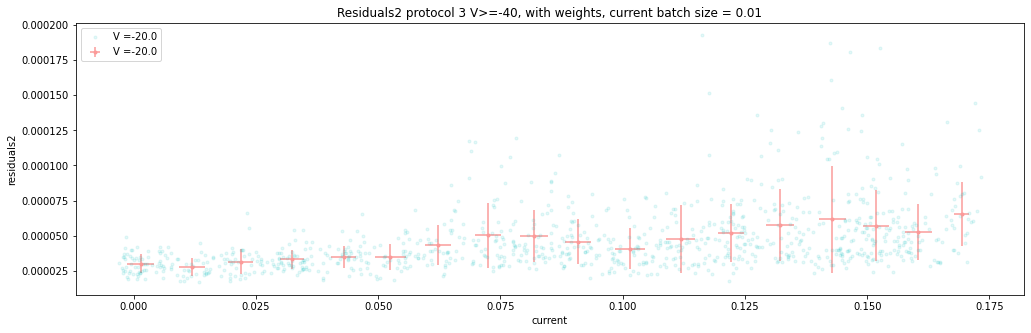

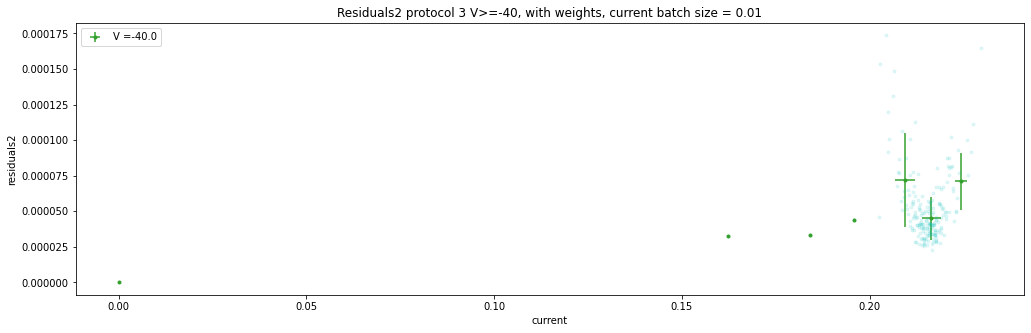

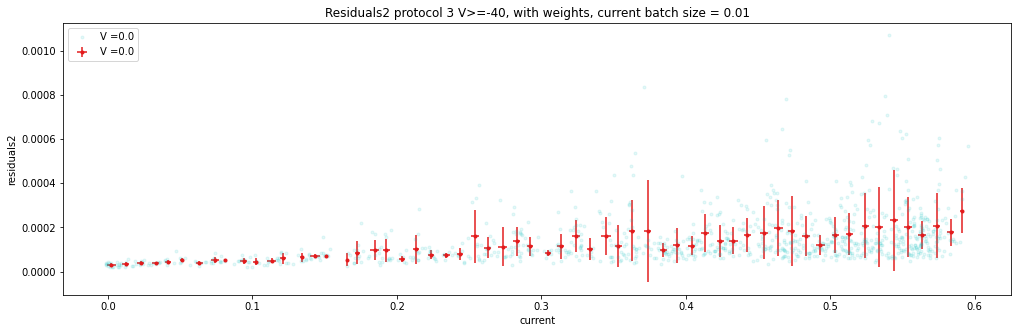

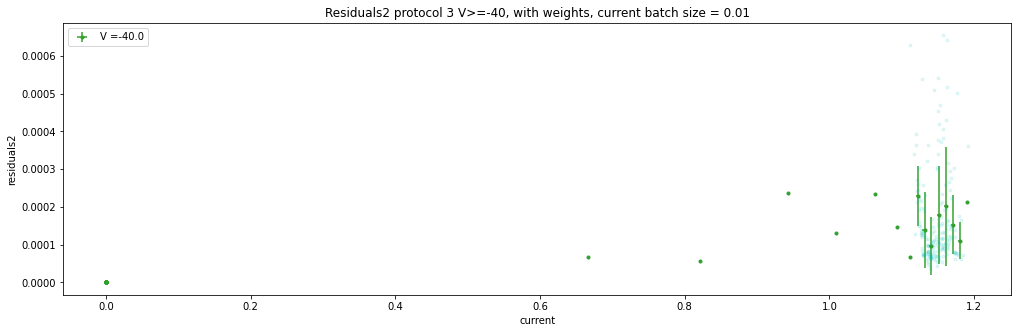

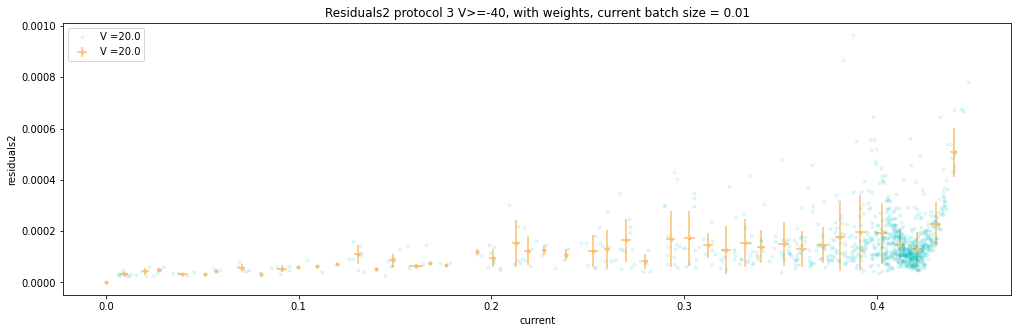

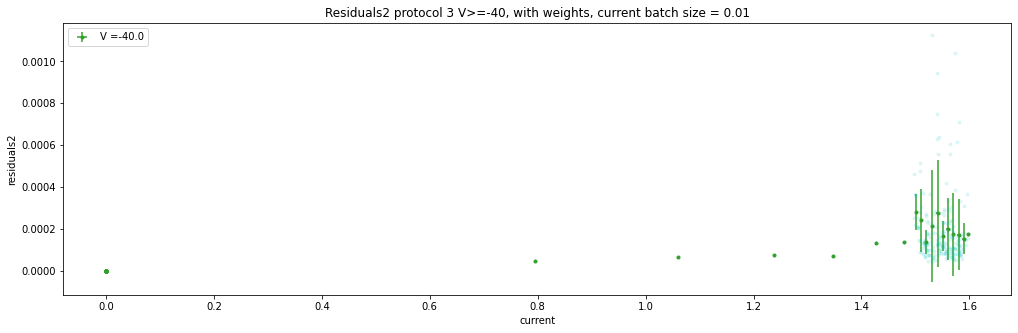

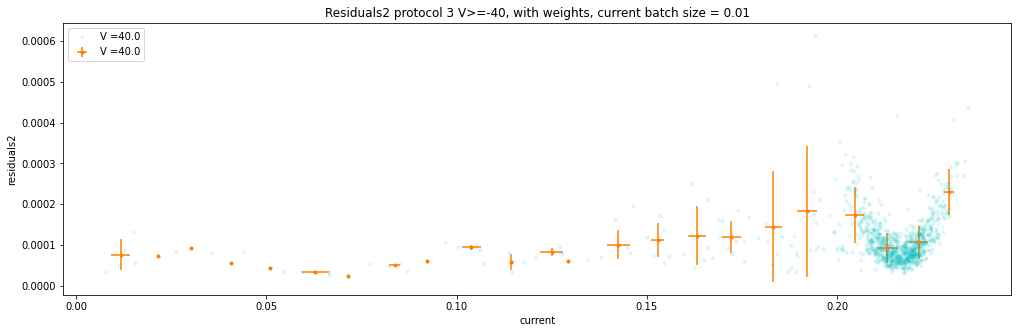

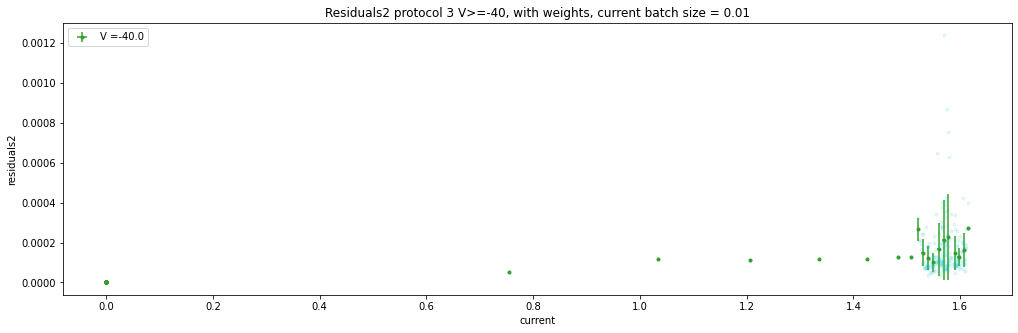

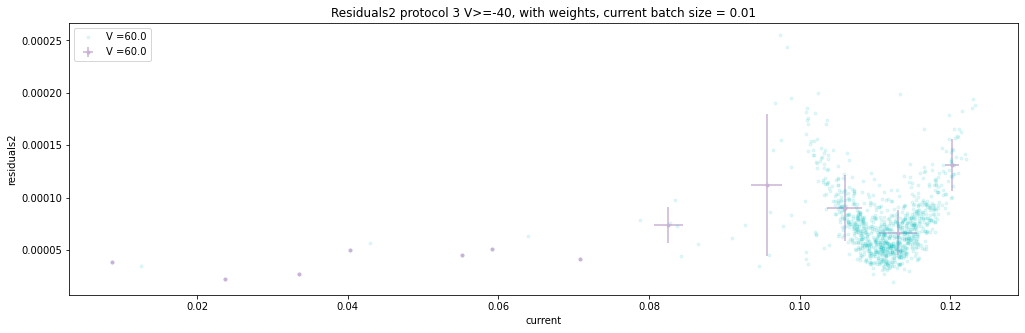

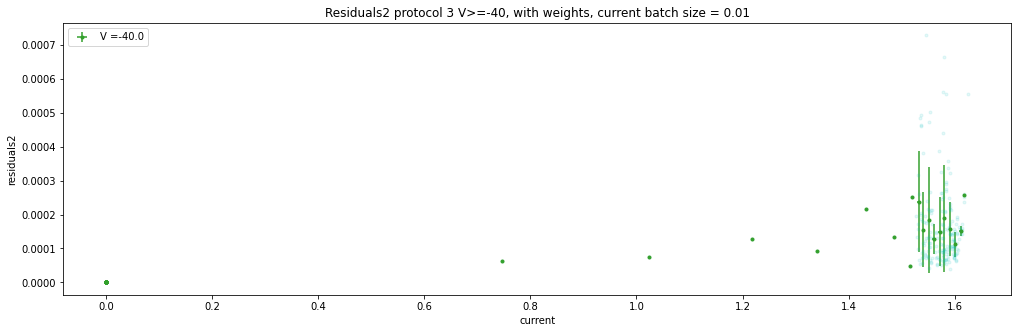

In [202]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
current_batch_size  = 0.01

residuals2_largerCurrents_weights_bytimeAcurrent = [None] * len(index_largerCurrents)
times_largerCurrents_weights_bytimeAcurrent = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_bytimeAcurrent = [None] * len(index_largerCurrents)
currents_largerCurrents_bytimeAcurrent = [None] * len(index_largerCurrents)
currents_largerCurrents_bytimeAcurrent_SORTindex = [None] * len(index_largerCurrents)

residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_bytimeAcurrent_meanbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_bytimeAcurrent_meanbatch = [None] * len(index_largerCurrents)

residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_bytimeAcurrent_stdbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_bytimeAcurrent_stdbatch = [None] * len(index_largerCurrents)


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    # find the index to surt the current
    currents_largerCurrents_bytimeAcurrent_SORTindex[index_i] = np.argsort(currents_largerCurrents_meanbatch[index_i])
    # arrange the vectors by current sort
    currents_largerCurrents_bytimeAcurrent[index_i] = currents_largerCurrents_meanbatch[index_i][currents_largerCurrents_bytimeAcurrent_SORTindex[index_i]]
    times_largerCurrents_weights_bytimeAcurrent[index_i] = times_largerCurrents_weights_meanbatch[index_i][currents_largerCurrents_bytimeAcurrent_SORTindex[index_i]]
    residuals2_largerCurrents_weights_bytimeAcurrent[index_i] = residuals2_largerCurrents_weights_meanbatch[index_i][currents_largerCurrents_bytimeAcurrent_SORTindex[index_i]]
    splines_largerCurrents_weights_bytimeAcurrent[index_i] = splines_largerCurrents_weights_meanbatch[index_i][currents_largerCurrents_bytimeAcurrent_SORTindex[index_i]]
    # BATCHING:
    current_batches = np.arange(currents_largerCurrents_bytimeAcurrent[index_i][0],currents_largerCurrents_bytimeAcurrent[index_i][-1],current_batch_size)
    last_current_in_batch = np.zeros(len(current_batches)+1).astype(int)
    empty_batches = []
    residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    splines_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    currents_largerCurrents_bytimeAcurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    splines_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    currents_largerCurrents_bytimeAcurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    for i in range(len(current_batches)):
        # deal with the last interval
        if i == len(current_batches)-1:
            last_current_in_batch[i+1] = len(currents_largerCurrents_bytimeAcurrent[index_i])-1
        else:
            last_current_in_batch[i+1] = np.argmax(currents_largerCurrents_bytimeAcurrent[index_i]>current_batches[i+1])

        if last_current_in_batch[i+1] == last_current_in_batch[i]:
            # in case there is no point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])        
        elif last_current_in_batch[i+1]  == last_current_in_batch[i]+1:
            # in case there is onely one point in that interval
            # make that point the mean, and zero std
            residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i][i] = residuals2_largerCurrents_weights_bytimeAcurrent[index_i][last_current_in_batch[i]]
            splines_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i][i] = splines_largerCurrents_weights_bytimeAcurrent[index_i][last_current_in_batch[i]]
            currents_largerCurrents_bytimeAcurrent_meanbatch[index_i][i] = currents_largerCurrents_bytimeAcurrent[index_i][last_current_in_batch[i]]
            residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i][i] = 0
            splines_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i][i] = 0
            currents_largerCurrents_bytimeAcurrent_stdbatch[index_i][i] = 0
        else:
            # otherwise calculate the mean and variance
            residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i][i] = np.mean(residuals2_largerCurrents_weights_bytimeAcurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            splines_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i][i] = np.mean(splines_largerCurrents_weights_bytimeAcurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            currents_largerCurrents_bytimeAcurrent_meanbatch[index_i][i] = np.mean(currents_largerCurrents_bytimeAcurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i][i] = np.std(residuals2_largerCurrents_weights_bytimeAcurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            splines_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i][i] = np.std(splines_largerCurrents_weights_bytimeAcurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            currents_largerCurrents_bytimeAcurrent_stdbatch[index_i][i] = np.std(currents_largerCurrents_bytimeAcurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
      
    
    print([index_i,empty_batches])
    #if len(empty_batches)>0:
    #    print(residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i][empty_batches])
    #    print([np.shape(residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i]),len(empty_batches)])
    #    residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i] = np.delete(residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i], 0,axis=0)
    #    print(np.shape(residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i]))





plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_bytimeAcurrent[index_i],residuals2_largerCurrents_weights_bytimeAcurrent[index_i], '.', color = pr3_voltage_constV_colors[i], alpha = 0.5, label = pr3_voltage_constV_labels_simple[i])
    #plt.plot(np.arange(currents_largerCurrents_bytimeAcurrent[index_i][0],currents_largerCurrents_bytimeAcurrent[index_i][-1],current_batch_size),residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i], 'r.', alpha=0.5,label='_nolegend_')
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 protocol 3 sorted by current, with weights ')
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    #plt.plot(currents_largerCurrents_bytimeAcurrent[index_i],residuals2_largerCurrents_weights_bytimeAcurrent[index_i], '.', color = pr3_voltage_constV_colors[i],alpha=0.5,label='by current')
    #plt.plot(currents_largerCurrents_bytimeAcurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i], '.', color = pr3_voltage_constV_colors[i], alpha = 0.5, label = pr3_voltage_constV_labels_simple[i])
    #plt.plot(currents_largerCurrents_bytimeAcurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i] + residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i], 'c',  alpha = 0.5, label = pr3_voltage_constV_labels_simple[i])
    plt.errorbar(currents_largerCurrents_bytimeAcurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i],xerr=currents_largerCurrents_bytimeAcurrent_stdbatch[index_i], yerr=residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()




for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.figure(figsize=(17, 5))
    plt.plot(currents_largerCurrents_bytimeAcurrent[index_i],residuals2_largerCurrents_weights_bytimeAcurrent[index_i], 'c.',  alpha = 0.1, label = pr3_voltage_constV_labels_simple[i])
    plt.errorbar(currents_largerCurrents_bytimeAcurrent_meanbatch[index_i],residuals2_largerCurrents_weights_bytimeAcurrent_meanbatch[index_i],xerr=currents_largerCurrents_bytimeAcurrent_stdbatch[index_i], yerr=residuals2_largerCurrents_weights_bytimeAcurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


## Rest of the protocols

### THE FOLLOWING HAS TO BE RE-EDITED!

# Import the data
pr2_time, pr2_voltage, pr2_current = np.loadtxt('Some_Kylies_data/KyliePR2cell123456910.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr4_time, pr4_voltage, pr4_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/cardiac_noise/KylieData/KyliePR4cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)



# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_2 = myokit.load_protocol('resources/pr2-activation-kinetics-2.mmt')
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
protocol_4 = myokit.load_protocol('resources/pr4-inactivation.mmt')
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


plt.figure(figsize=(15,4))
plt.title('Cell 5 currents ')
plt.plot(pr2_time, pr2_current, label='Pr2')
plt.plot(pr3_time, pr3_current, label='Pr3')
plt.plot(pr4_time, pr4_current, label='Pr4')
plt.plot(pr5_time, pr5_current, label='Pr5')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()


plt.show()


In [182]:
arr = np.zeros(89)
# remove element at index 2
arr_new = np.delete(arr, empty_batches)

print(len(empty_batches) )
print(np.shape(arr))
print(np.shape(arr_new))

70
(89,)
(19,)
